# Проект: Предсказание рисков сердечного приступа.

## Описание проекта.

В этом проекте предполагается работа с датасетом из открытого источника.<br/>
Нам предстоит разработать модель для предсказания риска сердечного приступа, используя данные пациентов, такие как возраст, привычки, состояние здоровья и результаты анализа крови, а также сделать для нее приложение на FastAPI или аналогичном фреймворке для получения предсказаний по пользовательскому запросу.<br/>
В начале проекта будет доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов.<br/>
Метрика на тестовом датасете будет измерена в ходе проверки работы. Также будет доступен скрипт, с помощью которого будет измеряться финальная метрика нашей модели.

### Описание данных.

Данные пациентов для предсказания риска сердечных приступов
- Идентификатор - id
- Антропометрические параметры (вес, возраст, рост)
- Привычки (курение, качество сна и т.д)
- Давление
- Наличие хронических заболеваний
- Биохимия крови
- Таргет - высокий или низкий риск поражения сердца

### Предварительный план.

**Первичный план задачи: предсказание риска сердечного приступа.**

* 1. Провести исследование датасета.
* 2. Выполнить предобработку данных. Привести столбцы к единому формату. Проверить наличие пропусков и дубликатов в датафреймах. Если есть пропуски, обаботать их.
* 3. Провести исследовательский анализ данных. Построить графики для каждого признака.
* 4. Подготовить данные. Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитываем особенности признаков и моделей.
* 5. Обучить модели. Выбрать лучшую модель и проверить её качество.
* 6. В ходе анализа датасетов определить наилучшую метрику оценки качества модели и обосновать ее выбор.
* 7. Подготовить скрипты и библиотеки для обработки данных и предсказания на тестовой выборке.
* 8. Написать инструмент для тестирования.
* 9. Подготовить предсказания на тестовой выборке. Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”. 
* 10. Оформить документацию.

**Базовая цель проекта.**

Разработать модель машинного обучения.<br/>
Подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.<br/>

**Результат.**

В результате у нас должно получиться приложение на FastAPI (или аналогичном фреймворке) которое принимает на вход путь к csv файлу тестовой выборки, выполняет предсказание (например, путем POST запроса к сервису) и возвращает ответ в формате JSON. Допускается для тестирования написать скрипт, который посылает запрос к запущенному ранее приложению, либо реализовать веб-интерфейс.<br/>
Обратить внимание, что будет оцениваться помимо качества модели структурированность, понятность и чистота кода, архитектура приложения. Обязательным является использование ООП, то есть составные части приложения должны быть реализованы в виде классов. Проект должен быть оформлен в виде репозитория на github (gitlab), должна быть написана документация к сервису с описанием для пользователя и описанием классов и методов в приложении, как если бы далее наш проект передавался пользователю.<br/>
В jupiter ноутбуках могут быть только исследования и эксперименты, если демонстрацию результатов работы приложения выносим в ноутбук - то кода приложения в ноутбуке быть не должно: он должен импортироваться в качестве внешних модулей.<br/>

## Загрузка данных.

### Загрузка библиотек.

In [1]:
try:
    %pip install catboost -q
    %pip install phik -q
    %pip install --upgrade scikit-learn==1.3.2 -q # scikit-learn==1.1.3 -q
    %pip install --upgrade seaborn -q
    %pip install --upgrade numba -q
    %pip install shap -q
except Exception as error:
    print(f'Ошибка загрузки: {error}')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import re
    import seaborn as sns
    import shap
    import warnings
    from catboost import CatBoostClassifier
    from joblib import dump
    from scipy import stats as st
    from phik import phik_matrix
    from phik.report import plot_correlation_matrix
    from sklearn.compose import ColumnTransformer
    from sklearn.dummy import DummyClassifier, DummyRegressor
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
    from sklearn.metrics import (
        accuracy_score,
        confusion_matrix,
        roc_auc_score,
        recall_score,
        precision_score,
        f1_score)
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import (
        OneHotEncoder,
        OrdinalEncoder,
        LabelEncoder,
        MinMaxScaler,
        StandardScaler)
except ImportError as error:
    print(f'Ошибка импорта: {error}')

### Константы.

In [3]:
ZERO = 0
ONE = 1
TWO = 2
THREE = 3
SIX = 6
TEN = 10
ID = 'id'
RANDOM_STATE = 42
TEST_SIZE = 0.25
COLOR_ONE = 'SteelBlue'
COLOR_TWO = 'Yellow'
COLOR_THREE = 'Green'
COLOR_FOUR = 'Blues'
PATH_HOME = '/Users/andrey/Python_dev/Jupiter/predictions_of_heart_attack_risk/datasets/'
PATH_HUB = '/datasets/'

### Загрузка данных из csv-файлов в датафрейм.

In [4]:
try:
    heart_test = pd.read_csv(f'{PATH_HOME}heart_test.csv')
    heart_train = pd.read_csv(f'{PATH_HOME}heart_train.csv')
except FileNotFoundError:
    try:
        heart_test = pd.read_csv(f'{PATH_HUB}heart_test.csv')
        heart_train = pd.read_csv(f'{PATH_HUB}heart_train.csv')
    except Exception as error:
        print(f'Что то пошло не так: {error}')

### Дополнительные настройки.

In [5]:
# Отключаем предупреждения.
pd.options.mode.chained_assignment = None

# Задаем два знака после запятой для чисел с плавающей запятой.
pd.options.display.float_format = '{:,.2f}'.format

# Игнорирование предупреждений.
warnings.filterwarnings("ignore")

# Установка опции для отображения максимальной ширины столбца.
pd.set_option('display.max_colwidth', None)

### Вспомогательные методы.

In [6]:
# Добавим датафреймы в словарик.
data_frames = {'heart_test': heart_test, 
               'heart_train': heart_train}

In [7]:
# Кастомный метод вывода информации о датафрейме.
def custom_info(value,
                name='',
                dtype_recom=False,
                is_result=True,
                sample=False,
                sample_quantity=TEN,
                head_value=0):
    result = (
        pd.DataFrame(value.count(),
                     columns=['non_null_count']))
    result['dtype'] = (
        pd.DataFrame(value.dtypes, 
                     columns=['dtype']))

    if name:
        print(f'Статистика по столбцам, выборка {name}.')

    if dtype_recom:
        result['dtype_recomended'] = (
            pd.DataFrame(
                value.convert_dtypes()
                .dtypes.to_frame()
                .rename(columns={0: 'dtype_recomended'}), 
                        columns=['dtype_recomended']))

    if is_result:
        display(result)
    print(f'Количество записей: {len(value)}')
    print(f'Количество столбцов: {len(value.columns)}')

    if sample:
        display(value.sample(sample_quantity).T)

    if head_value != 0:
        display(value.head(head_value).T)

In [8]:
# Проверка пустых значений в датафрейме.
def count_none_values_table(value, name=''):
    try:
        result = (
            (value.isna().sum())
            .to_frame()
            .rename(columns={0: 'count_none'})
            .query('count_none > 0'))
        if len(result) != 0:
            print(f'Пропущенные значения в датафрейме {name}.'.strip())
            display(result.sort_values(by='count_none', ascending=True))
        else:
            print(f'В датафрейме {name} нет пропущенных значений.'
                  .replace('  ', ' '))
    except Exception as error:
        print(f'Что пошло не так: {error}')

### Общая информация о полученных датафреймах.

Посмотрим на статистику по столбцам.<br/>
Выведем на экран по 10 случайных позиций данных из каждого датафрейма. Посмотрим на их состав.

In [9]:
for name, data in data_frames.items():
    custom_info(data, name, sample=True)

Статистика по столбцам, выборка heart_test.


,non_null_count,dtype
Unnamed: 0,966,int64
Age,966,float64
Cholesterol,966,float64
Heart rate,966,float64
Diabetes,935,float64
Family History,935,float64
Smoking,935,float64
Obesity,935,float64
Alcohol Consumption,935,float64
Exercise Hours Per Week,966,float64


Количество записей: 966
Количество столбцов: 27


,218,707,195,148,12,842,799,660,256,238
Unnamed: 0,218,707,195,148,12,842,799,660,256,238
Age,0.49,0.39,0.19,0.44,0.49,0.51,0.11,0.12,0.46,0.62
Cholesterol,0.68,0.55,0.12,0.15,0.70,0.29,0.16,0.05,0.57,0.14
Heart rate,0.05,0.05,0.03,0.06,0.03,0.06,0.05,0.04,0.06,0.08
Diabetes,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
Family History,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
Smoking,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00
Obesity,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
Alcohol Consumption,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00
Exercise Hours Per Week,0.70,0.85,0.68,0.81,0.24,0.24,0.99,1.00,0.22,0.11


Статистика по столбцам, выборка heart_train.


,non_null_count,dtype
Unnamed: 0,8685,int64
Age,8685,float64
Cholesterol,8685,float64
Heart rate,8685,float64
Diabetes,8442,float64
Family History,8442,float64
Smoking,8442,float64
Obesity,8442,float64
Alcohol Consumption,8442,float64
Exercise Hours Per Week,8685,float64


Количество записей: 8685
Количество столбцов: 28


,5287,8385,1377,4558,4,6595,6435,457,7899,3578
Unnamed: 0,5287,8385,1377,4558,4,6595,6435,457,7899,3578
Age,0.25,0.25,0.63,0.09,0.78,0.45,0.20,0.47,0.07,0.74
Cholesterol,0.37,0.60,0.50,0.16,0.76,0.50,0.49,0.89,0.25,0.75
Heart rate,0.05,0.03,1.00,0.03,0.02,0.06,0.07,0.07,0.04,0.07
Diabetes,0.00,0.00,NaN,0.00,0.00,NaN,0.00,1.00,1.00,1.00
Family History,0.00,1.00,NaN,1.00,0.00,NaN,1.00,1.00,1.00,0.00
Smoking,1.00,0.00,NaN,0.00,1.00,NaN,1.00,1.00,1.00,1.00
Obesity,0.00,1.00,NaN,0.00,0.00,NaN,1.00,0.00,0.00,1.00
Alcohol Consumption,1.00,1.00,NaN,1.00,1.00,NaN,1.00,1.00,1.00,1.00
Exercise Hours Per Week,0.17,0.92,0.50,0.42,0.41,0.50,0.60,0.50,0.80,0.83


### Описание полей датафремов.

**Основные метрики пациента.**

- **Age** — Возраст пациента.
- **Gender** — Пол пациента (например, Male/Female или числовое кодирование).
- **BMI** — Индекс массы тела (Body Mass Index = вес / рост²).
- **Income** — Доход пациента (возможно, в условных единицах или категориях).

**Клинические показатели.**

- **Cholesterol** — Уровень холестерина в крови (мг/дл или ммоль/л).
- **Blood sugar** — Уровень сахара в крови (глюкоза, возможно натощак).
- **Triglycerides** — Уровень триглицеридов в крови (липидный профиль).
- **Systolic blood pressure** — Систолическое артериальное давление (верхнее значение, мм рт. ст.).
- **Diastolic blood pressure** — Диастолическое артериальное давление (нижнее значение, мм рт. ст.).
- **Heart rate** — Частота сердечных сокращений (ударов в минуту).
- **CK-MB** — Уровень креатинкиназы-MB (фермент, маркер повреждения сердца).
- **Troponin** — Уровень тропонина (белок, указывающий на инфаркт миокарда).

**Факторы образа жизни.**

- **Smoking** — Курение (бинарный признак: 1/0 или категории).
- **Alcohol Consumption** — Употребление алкоголя.
- **Exercise Hours Per Week** — Часы физических упражнений в неделю.
- **Physical Activity Days Per Week** — Дни физической активности в неделю.
- **Sedentary Hours Per Day** — Часы сидячего образа жизни в день.
- **Sleep Hours Per Day** — Часы сна в сутки.
- **Diet** — Тип питания.

**Медицинская история и риски.**

- **Diabetes** — Наличие диабета (бинарный: да/нет).
- **Family History** — Наследственность по сердечным заболеваниям (бинарный или категориальный).
- **Obesity** — Ожирение (бинарный или по шкале, например, "Normal", "Overweight", "Obese").
- **Previous Heart Problems** — Предыдущие проблемы с сердцем (бинарный).
- **Medication Use** — Приём лекарств (бинарный или тип препаратов).
- **Stress Level** — Уровень стресса (например, шкала от 1 до 10).

**Целевая переменная.**

- **Heart Attack Risk (Binary)** — Бинарный показатель риска инфаркта (1 — высокий риск, 0 — низкий).

**Технические поля.**

- **Unnamed: 0** — Технический столбец (возможно, индекс строки, оставшийся после загрузки данных).
- **id** — Уникальный идентификатор пациента.

По результату изучения общей информации о каждом датафрейме, наблюдаем следующую картину:
* Наборы данных далее датафреймы, содержат информацию об основных метриках пациента, клинических показателях, факторах образа жизни, медицинской истории и рисках.
* В датафреймах есть колонка id (уникальный идентификатор пациента).
* Типы данных у некотрых признаков следует привести к корректным значениям. 
* В датафреймах есть пропущенные значения.
* Названия колонок в датафреймах следует привести к единому формату, в соответствии со «змеиным_регистром».

###  Предобработка данных.

### Преобразуем названия колонок в датафреймах к единому формату, в соответствии со «змеиным_регистром».

In [10]:
def to_snake_case(column_name):
    # Заменяем пробелы, дефисы и двоеточия на подчёркивания.
    value = re.sub(r'[\s\-:]', '_', column_name)
    # Вставляем подчёркивание между заглавной и строчной буквой (для camelCase).
    value = re.sub(r'([a-z])([A-Z])', r'\1_\2', value)
    # Заменяем множественные подчёркивания на одинарные.
    value = re.sub(r'_+', '_', value)
    # Приводим к нижнему регистру
    return value.lower()

In [11]:
def prepare_columns(data):
    columns_dict = {}
    columns = data.columns.tolist()
    
    for col in columns:
        columns_dict[col] = to_snake_case(col)

    return columns_dict

In [12]:
for name, data in data_frames.items():
    print(f'\nРезультирующая таблица по изменению названия столбцов в датафрейме {name}:')
    result = pd.DataFrame(data.columns, columns=['columns_before'])
    data.rename(columns=prepare_columns(data), inplace=True)
    result['columns_after'] = pd.DataFrame(data.columns, columns=['columns_after'])
    display(result)


Результирующая таблица по изменению названия столбцов в датафрейме heart_test:


,columns_before,columns_after
0,Unnamed: 0,unnamed_0
1,Age,age
2,Cholesterol,cholesterol
3,Heart rate,heart_rate
4,Diabetes,diabetes
5,Family History,family_history
6,Smoking,smoking
7,Obesity,obesity
8,Alcohol Consumption,alcohol_consumption
9,Exercise Hours Per Week,exercise_hours_per_week



Результирующая таблица по изменению названия столбцов в датафрейме heart_train:


,columns_before,columns_after
0,Unnamed: 0,unnamed_0
1,Age,age
2,Cholesterol,cholesterol
3,Heart rate,heart_rate
4,Diabetes,diabetes
5,Family History,family_history
6,Smoking,smoking
7,Obesity,obesity
8,Alcohol Consumption,alcohol_consumption
9,Exercise Hours Per Week,exercise_hours_per_week


#### Проверим наличие пропусков в датафреймах.

In [13]:
for name, data in data_frames.items():
    count_none_values_table(data, name)

Пропущенные значения в датафрейме heart_test.


,count_none
diabetes,31
family_history,31
smoking,31
obesity,31
alcohol_consumption,31
previous_heart_problems,31
medication_use,31
stress_level,31
physical_activity_days_per_week,31


Пропущенные значения в датафрейме heart_train.


,count_none
diabetes,243
family_history,243
smoking,243
obesity,243
alcohol_consumption,243
previous_heart_problems,243
medication_use,243
stress_level,243
physical_activity_days_per_week,243


#### Исследование датафреймов на явное дублирование данных.

In [14]:
for name, data in data_frames.items():
    print(f'Количество явных дубликатов в датафрейме {name} - ', end='')
    print(data.duplicated().sum());

Количество явных дубликатов в датафрейме heart_test - 0
Количество явных дубликатов в датафрейме heart_train - 0


#### Исследование датафреймов на неявное дублирование данных.

In [15]:
# Создадим метод для проверки уникальных значений в столбцах.
def check_unique_value(data_frame=data_frames, type='object', cols=[]):
    for name, data in data_frame.items():
        # создаём список с категориями
        if not cols:
            cols = data.drop(columns=[ID]).select_dtypes(include=type).columns.tolist()
        if cols:
            print(f'\nУникальные значения поля(ей) в датафрейме {name}:')
            for value in cols:
                print(f'{value:16} - {data[value].unique().tolist()}')   
            print(f'Размер датафрейма - {data.shape}')

In [16]:
# Проверим уникальные значения в текстовых столбцах.
check_unique_value()


Уникальные значения поля(ей) в датафрейме heart_test:
gender           - ['Male', 'Female', '1.0', '0.0']
Размер датафрейма - (966, 27)

Уникальные значения поля(ей) в датафрейме heart_train:
gender           - ['Male', 'Female', '1.0', '0.0']
Размер датафрейма - (8685, 28)


In [17]:
for name, data in data_frames.items():
    # print(data['Gender'].nunique())  # Число уникальных (без NaN)
    counts = data['gender'].value_counts(dropna=False)
    display(counts)
    # print(f"\nДатафрейм {name} поле {data['Gender'].value_counts(dropna=False)}")  # Частоты + NaN

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

In [18]:

for name, data in data_frames.items():
    data['gender'] = (np.where(data['gender'] == 'Male', '1.0', data['gender']))
    data['gender'] = (np.where(data['gender'] == 'Female', '0.0', data['gender']))
    data['gender'] = data['gender'].astype('float64').astype('int64')

In [19]:
# Проверим уникальные значения в поле 'Gender'.
check_unique_value(cols=['gender'])


Уникальные значения поля(ей) в датафрейме heart_test:
gender           - [1, 0]
Размер датафрейма - (966, 27)

Уникальные значения поля(ей) в датафрейме heart_train:
gender           - [1, 0]
Размер датафрейма - (8685, 28)


Проверим наличие дублей в числовом поле уникального идентификатора.

In [20]:
# Проверка наличия дублей в поле уникальный идентификатор, в датафреймах.
for name, data in data_frames.items():
    print(f"Количество дублей в поле {ID}, датафрейм {name} - \
{data[ID].duplicated().sum()}")

Количество дублей в поле id, датафрейм heart_test - 0
Количество дублей в поле id, датафрейм heart_train - 0


In [21]:
# Проверка наличия дублей в поле 'unnamed_0', в датафреймах.
for name, data in data_frames.items():
    print(f"Количество дублей в поле unnamed_0, датафрейм {name} - \
{data['unnamed_0'].duplicated().sum()}")

Количество дублей в поле unnamed_0, датафрейм heart_test - 0
Количество дублей в поле unnamed_0, датафрейм heart_train - 0


In [22]:
for name, data in data_frames.items():
    display(data[[ID, 'unnamed_0']].T)
    print(f'Размер датафрейма {name} - {data.shape}\n')

,0,1,2,3,4,5,6,7,8,9,...,956,957,958,959,960,961,962,963,964,965
id,7746,4202,6632,4639,4825,1076,5020,4267,4003,2519,...,2932,6792,6911,1373,2492,9271,8012,2456,4984,6521
unnamed_0,0,1,2,3,4,5,6,7,8,9,...,956,957,958,959,960,961,962,963,964,965


Размер датафрейма heart_test - (966, 27)



,0,1,2,3,4,5,6,7,8,9,...,8675,8676,8677,8678,8679,8680,8681,8682,8683,8684
id,2664,9287,5379,8222,4047,5817,5580,4963,4521,2455,...,8322,5578,4426,466,6265,5734,5191,5390,860,7270
unnamed_0,0,1,2,3,4,5,6,7,8,9,...,8675,8676,8677,8678,8679,8680,8681,8682,8683,8684


Размер датафрейма heart_train - (8685, 28)



Поле 'unnamed_0' скорее всего использовалось, как технический столбец, возможно, индекс строки, оставшийся после загрузки данных.<br/>
Принимаем решение по его удалению.

In [23]:
for name, data in data_frames.items():
    data.drop(columns=['unnamed_0'], inplace=True) # Удаляем ненужный столбец

In [24]:
# Обновим датафреймы в словаре.
data_frames = {'heart_test': heart_test, 
               'heart_train': heart_train}

In [25]:
for name, data in data_frames.items():
    custom_info(data, name, sample=False)

Статистика по столбцам, выборка heart_test.


,non_null_count,dtype
age,966,float64
cholesterol,966,float64
heart_rate,966,float64
diabetes,935,float64
family_history,935,float64
smoking,935,float64
obesity,935,float64
alcohol_consumption,935,float64
exercise_hours_per_week,966,float64
diet,966,int64


Количество записей: 966
Количество столбцов: 26
Статистика по столбцам, выборка heart_train.


,non_null_count,dtype
age,8685,float64
cholesterol,8685,float64
heart_rate,8685,float64
diabetes,8442,float64
family_history,8442,float64
smoking,8442,float64
obesity,8442,float64
alcohol_consumption,8442,float64
exercise_hours_per_week,8685,float64
diet,8685,int64


Количество записей: 8685
Количество столбцов: 27


### Исследовательский анализ данных.

#### Проверка количественных значений.

In [26]:
for name, data in data_frames.items():
    # Исключим последний столбец втором содержится ID пациента.
    display(data.iloc[:,:-ONE:].describe().T)
    print(f'Размер датафрейма {name} - {data.shape}\n')

,count,mean,std,min,25%,50%,75%,max
age,966.00,0.45,0.23,0.04,0.25,0.46,0.64,0.85
cholesterol,966.00,0.49,0.28,0.00,0.24,0.50,0.71,1.00
heart_rate,966.00,0.05,0.04,0.00,0.04,0.05,0.07,1.00
diabetes,935.00,0.66,0.48,0.00,0.00,1.00,1.00,1.00
family_history,935.00,0.48,0.50,0.00,0.00,0.00,1.00,1.00
smoking,935.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
obesity,935.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
alcohol_consumption,935.00,0.58,0.49,0.00,0.00,1.00,1.00,1.00
exercise_hours_per_week,966.00,0.49,0.28,0.00,0.24,0.50,0.73,1.00
diet,966.00,1.05,0.88,0.00,0.00,1.00,2.00,3.00


Размер датафрейма heart_test - (966, 26)



,count,mean,std,min,25%,50%,75%,max
age,"8,685.00",0.45,0.23,0.00,0.26,0.46,0.64,1.00
cholesterol,"8,685.00",0.50,0.28,0.00,0.27,0.50,0.75,1.00
heart_rate,"8,685.00",0.05,0.02,0.00,0.03,0.05,0.07,1.00
diabetes,"8,442.00",0.65,0.48,0.00,0.00,1.00,1.00,1.00
family_history,"8,442.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
smoking,"8,442.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
obesity,"8,442.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00
alcohol_consumption,"8,442.00",0.60,0.49,0.00,0.00,1.00,1.00,1.00
exercise_hours_per_week,"8,685.00",0.50,0.28,0.00,0.26,0.50,0.75,1.00
diet,"8,685.00",1.06,0.87,0.00,0.00,1.00,2.00,3.00


Размер датафрейма heart_train - (8685, 27)



In [27]:
# Составим список числовых полей.
num_columns = ['age',
               'bmi',
               'income',
               'cholesterol',
               'blood_sugar',
               'triglycerides',
               'systolic_blood_pressure',
               'diastolic_blood_pressure',
               'heart_rate',
               'ck_mb',
               'troponin',
               'exercise_hours_per_week',
               'sedentary_hours_per_day',
               'sleep_hours_per_day'
               ]
display(num_columns)

['age',
 'bmi',
 'income',
 'cholesterol',
 'blood_sugar',
 'triglycerides',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
 'heart_rate',
 'ck_mb',
 'troponin',
 'exercise_hours_per_week',
 'sedentary_hours_per_day',
 'sleep_hours_per_day']

In [28]:
# Составим список бинарных полей.
ord_columns = ['diabetes',
               'gender',
               'smoking',
               'alcohol_consumption',
               'family_history',
               'obesity',
               'previous_heart_problems',
               'medication_use',
               'physical_activity_days_per_week'
               ]
display(ord_columns)

['diabetes',
 'gender',
 'smoking',
 'alcohol_consumption',
 'family_history',
 'obesity',
 'previous_heart_problems',
 'medication_use',
 'physical_activity_days_per_week']

In [29]:
# Составим список категориальных полей.
ohe_columns = ['diet',
               'stress_level'
               ]
display(ohe_columns)

['diet', 'stress_level']

In [30]:
# Ввыведем строки где есть хотя бы один пропуск.
for name, data in data_frames.items():
    try:
        print(f'Sample датафрейма {name} где есть строки с пропусками.')
        display(data[data.isna().any(axis=1)].sample(TEN).T)
    except Exception as error:
        print(f'В датафрейме {name} пропуски в строках отсутствуют {error}.')

Sample датафрейма heart_test где есть строки с пропусками.


,631,339,921,60,758,27,484,563,456,475
age,0.57,0.35,0.55,0.37,0.55,0.37,0.62,0.52,0.35,0.28
cholesterol,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
heart_rate,0.05,0.05,0.04,0.06,0.09,0.03,0.09,0.08,1.00,0.04
diabetes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_history,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obesity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alcohol_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exercise_hours_per_week,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
diet,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00


Sample датафрейма heart_train где есть строки с пропусками.


,8138,1425,204,3401,5925,4014,2132,3192,8103,1182
age,0.65,0.38,0.67,0.46,0.30,0.52,0.63,0.35,0.55,0.67
cholesterol,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
heart_rate,0.05,0.04,0.07,0.03,0.07,0.05,0.06,0.05,0.09,0.05
diabetes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
family_history,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
obesity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alcohol_consumption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exercise_hours_per_week,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
diet,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00


Принимаем решение удалить пропуски.
Матаматическое вычисление параметров пациента недопустимо.

In [31]:
count_shape = []
counter = ZERO
for name, data in data_frames.items():
    # Сохраним размер датафрейма до удаления.
    count_shape.append(data.shape[ZERO])
    # Удалим пропуски.
    data.dropna(inplace=True)
    # Приведем поля к типу в соответствии с их значением.
    data[ord_columns] = data[ord_columns].astype('int64')
    data[ohe_columns] = data[ohe_columns].astype('int64')
    # Выведем статистику.
    print(f'Удалено в {name} - {count_shape[counter] - data.shape[ZERO]} записей, ', end='')
    print(f'процент потерь - {100 - data.shape[ZERO] / count_shape[counter] * 100:.2f} %')
    counter +=  1

Удалено в heart_test - 31 записей, процент потерь - 3.21 %
Удалено в heart_train - 243 записей, процент потерь - 2.80 %


Процент потерь находится в допустимом пределе.

In [32]:
# Обновим датафреймы в словаре.
data_frames = {'heart_test': heart_test, 
               'heart_train': heart_train}

In [33]:
# Проверим наличие пропусков после удаления.
for name, data in data_frames.items():
    count_none_values_table(data, name)

В датафрейме heart_test нет пропущенных значений.
В датафрейме heart_train нет пропущенных значений.


In [34]:
check_unique_value(type='int64')


Уникальные значения поля(ей) в датафрейме heart_test:
diabetes         - [0, 1]
family_history   - [1, 0]
smoking          - [1, 0]
obesity          - [1, 0]
alcohol_consumption - [1, 0]
diet             - [2, 0, 1]
previous_heart_problems - [0, 1]
medication_use   - [0, 1]
stress_level     - [8, 5, 10, 7, 1, 4, 9, 6, 3, 2]
physical_activity_days_per_week - [1, 0, 7, 5, 3, 2, 4, 6]
gender           - [1, 0]
Размер датафрейма - (935, 26)

Уникальные значения поля(ей) в датафрейме heart_train:
diabetes         - [1, 0]
family_history   - [1, 0]
smoking          - [1, 0]
obesity          - [1, 0]
alcohol_consumption - [1, 0]
diet             - [1, 2, 0]
previous_heart_problems - [1, 0]
medication_use   - [0, 1]
stress_level     - [8, 9, 6, 3, 7, 1, 10, 2, 5, 4]
physical_activity_days_per_week - [3, 2, 0, 5, 6, 4, 7, 1]
gender           - [1, 0]
Размер датафрейма - (8442, 27)


Сохраним подготовленный датафрейм heart_test в csv.<br/>
Будем использовать его для отладки и тестирования API приложения.

In [35]:
# Сохраним датафрейм heart_test в csv файл.
heart_test.to_csv('datasets/test.csv', index=False)

# Проверка сохранения.
try:
    custom_info(pd.read_csv('datasets/test.csv'), 'test', sample=True)
except Exception as error:
    print(f'Что то пошло не так: {error}')

Статистика по столбцам, выборка test.


,non_null_count,dtype
age,935,float64
cholesterol,935,float64
heart_rate,935,float64
diabetes,935,int64
family_history,935,int64
smoking,935,int64
obesity,935,int64
alcohol_consumption,935,int64
exercise_hours_per_week,935,float64
diet,935,int64


Количество записей: 935
Количество столбцов: 26


,613,726,895,734,787,552,757,818,530,859
age,0.16,0.84,0.19,0.51,0.85,0.52,0.56,0.40,0.79,0.18
cholesterol,0.04,0.09,0.21,0.40,0.16,0.77,0.03,0.31,0.56,0.04
heart_rate,0.05,0.08,0.06,0.06,0.06,0.04,0.04,0.04,0.02,0.08
diabetes,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
family_history,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
smoking,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
obesity,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00
alcohol_consumption,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
exercise_hours_per_week,0.53,0.68,0.98,0.78,0.28,0.86,0.03,0.55,0.29,0.57
diet,1.00,2.00,1.00,2.00,2.00,1.00,1.00,1.00,1.00,0.00


#### Построим графики для непрерывных количественных значений.

In [36]:
# Вывод статистики по столбцу датафрейма.
def stats_column(value, column='', text='', is_sum=False):
    print(f"\nСтатистика по столбцу '{column}' {text}".strip()+":")
    result = value[column].describe().to_frame()
    if is_sum:
        result = (pd.concat(
            [result, 
             pd.DataFrame({column:[value[column].sum()]}, index=['sum'])]))
    result = result.T
    result['median'] = value[column].agg('median')
    display(result)

In [37]:
# Кастомный метод для построения гистограммы и диаграммы размаха.
def custom_hist(df, df_name, add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во пациентов'
    columns = df.drop(columns=del_columns).select_dtypes(include=['float64']).columns.to_list()
    columns.extend(add_columns)

    for column in columns:
        stats_column(value=df, column=column, text=f'датафрейма {df_name}', is_sum=False)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

        sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black', ax=ax[ZERO])
        ax[ZERO].axvline(df[column].mean(), color='red', linestyle='--', label='Среднее')
        ax[ZERO].axvline(df[column].median(), color='green', linestyle=':', label='Медиана')
        ax[ZERO].set_title(f'Распределение признака "{column}"')
        ax[ZERO].set_ylabel(ylabel)
        ax[ZERO].legend()

        sns.boxplot(df[column], ax=ax[ONE])
        ax[ONE].set_title('Диаграмма размаха', fontsize=15)
        ax[ONE].set_xlabel(None)

        plt.show()

In [38]:
# Сохраним целевой признак в переменную.
target_attribute = 'heart_attack_risk_(binary)'


График для непрерывных количественных значений датафрейма heart_test.

Статистика по столбцу 'age' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
age,935.00,0.45,0.23,0.04,0.24,0.46,0.65,0.85,0.46


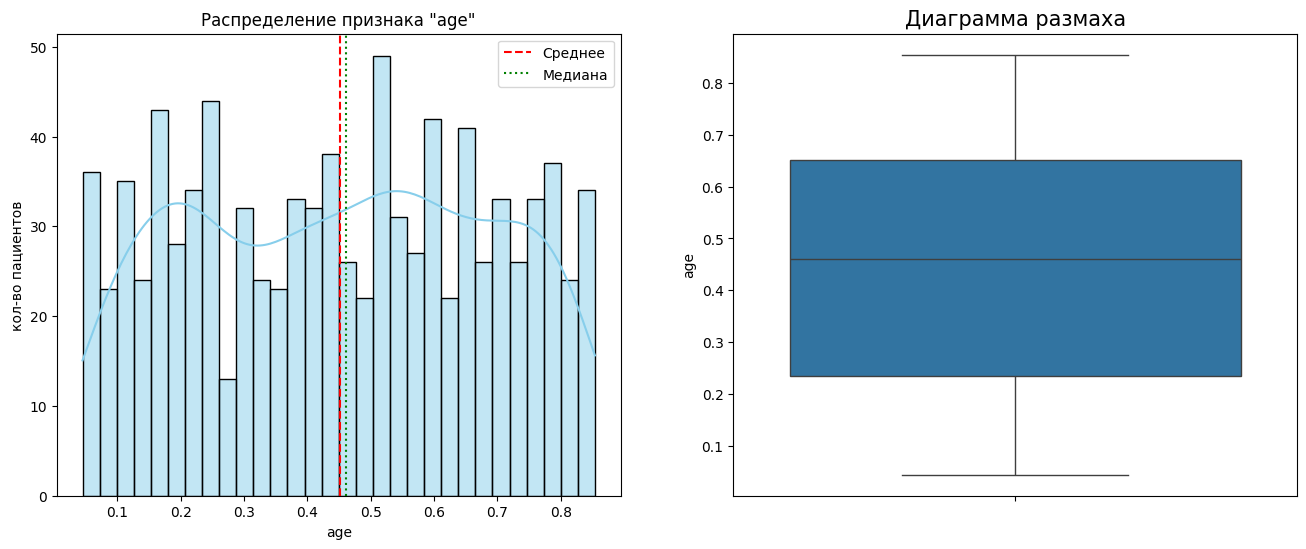

Статистика по столбцу 'cholesterol' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
cholesterol,935.00,0.49,0.29,0.00,0.24,0.49,0.72,1.00,0.49


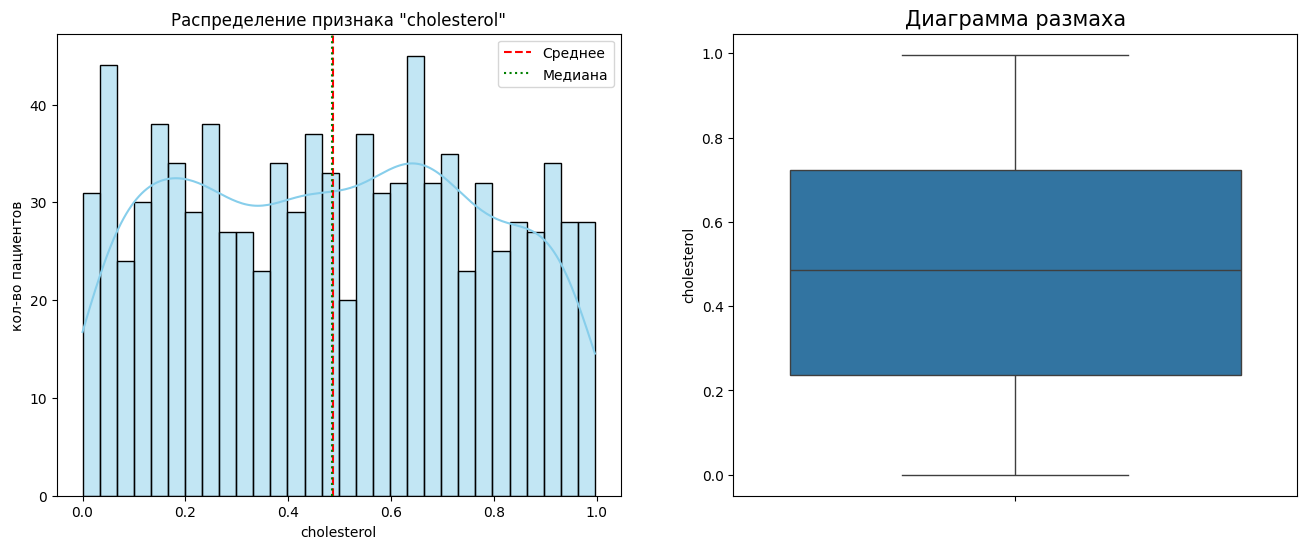

Статистика по столбцу 'heart_rate' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
heart_rate,935.00,0.05,0.02,0.02,0.04,0.05,0.07,0.08,0.05


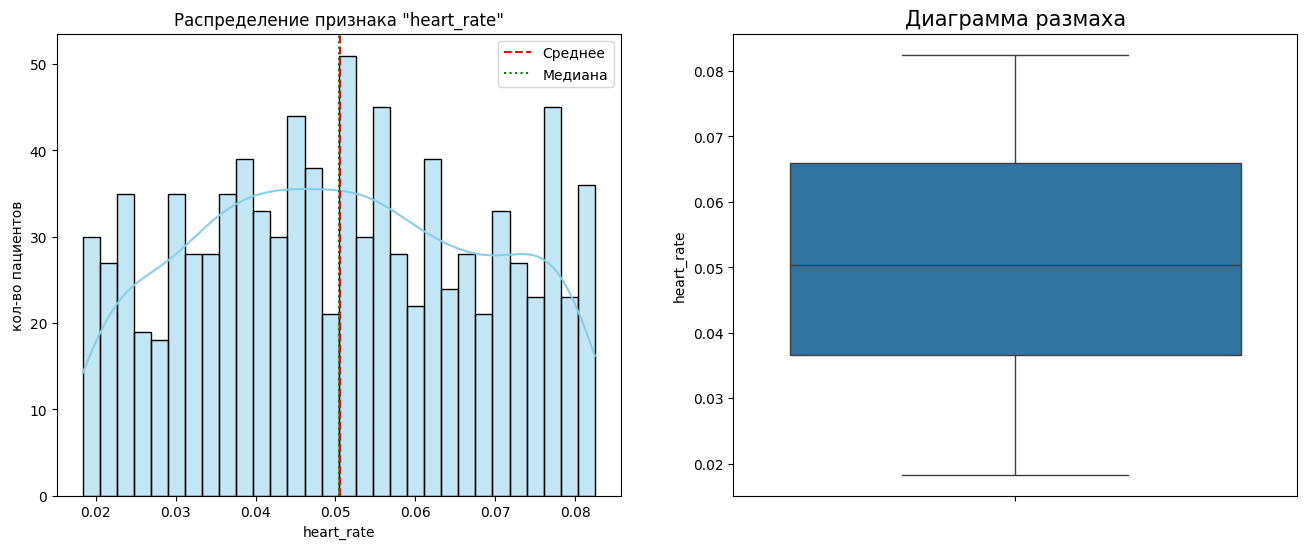

Статистика по столбцу 'exercise_hours_per_week' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
exercise_hours_per_week,935.00,0.49,0.29,0.00,0.24,0.49,0.74,1.00,0.49


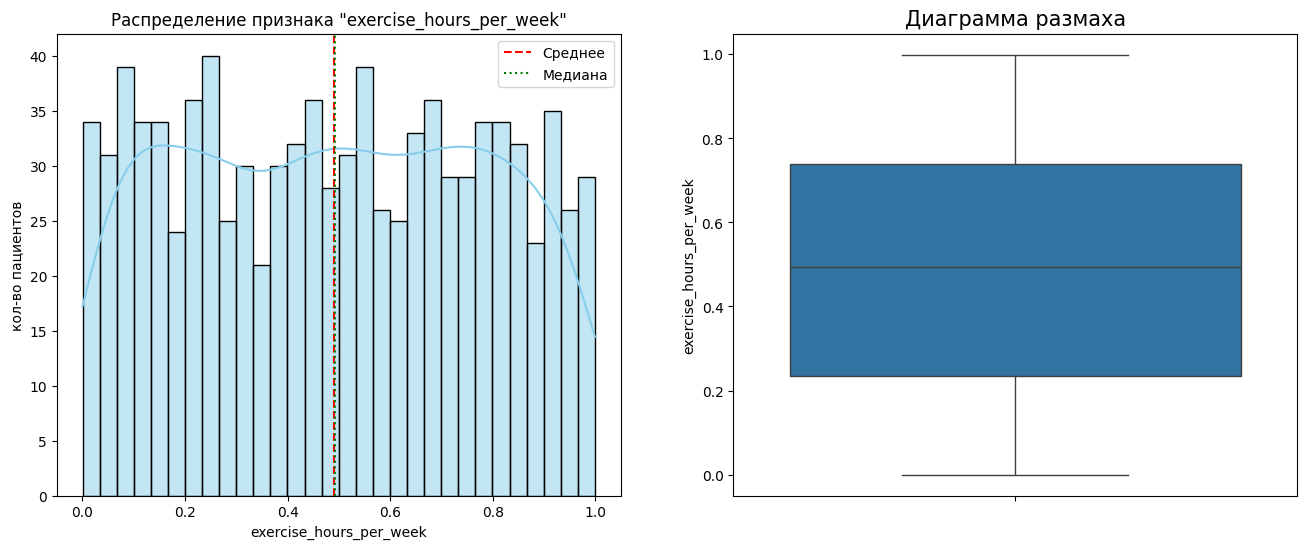

Статистика по столбцу 'sedentary_hours_per_day' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
sedentary_hours_per_day,935.00,0.51,0.29,0.00,0.25,0.52,0.77,1.00,0.52


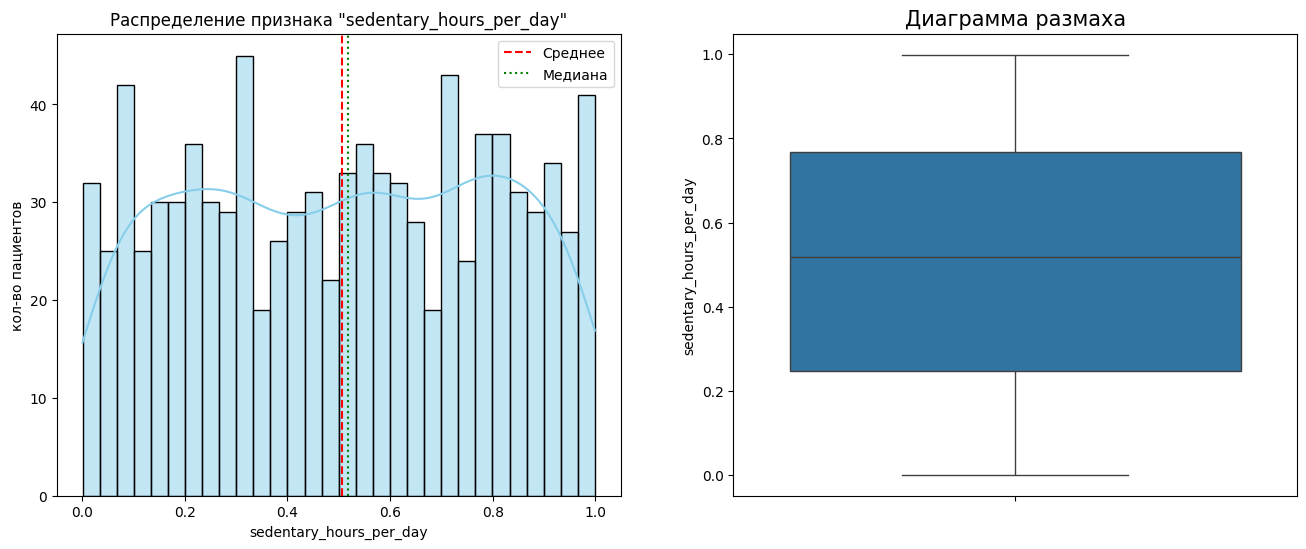

Статистика по столбцу 'income' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
income,935.00,0.48,0.28,0.00,0.26,0.48,0.72,1.00,0.48


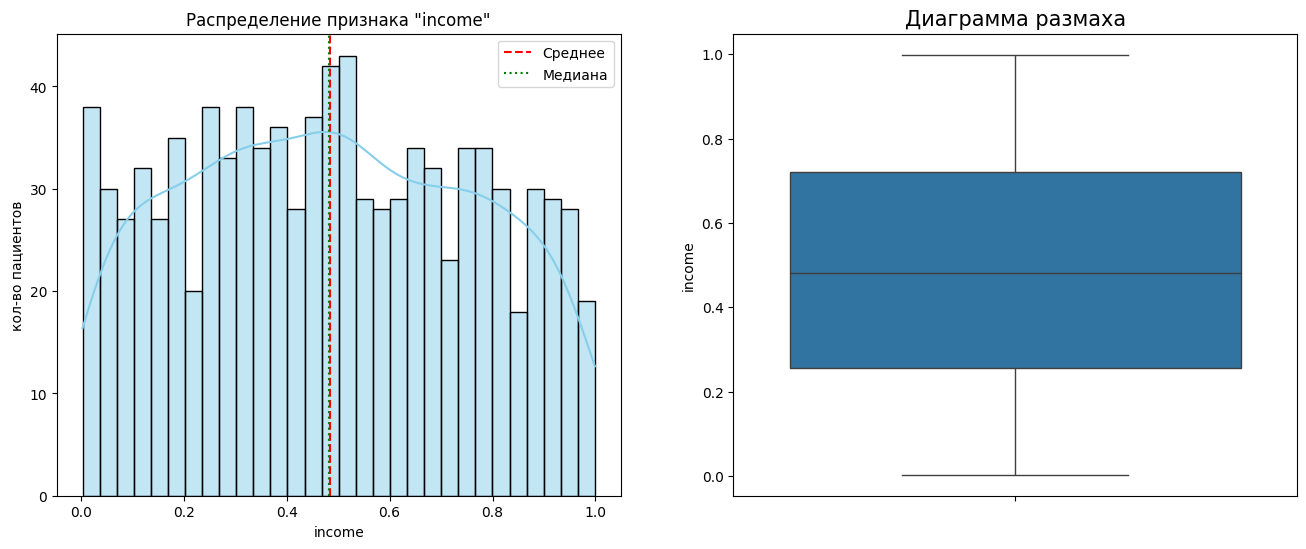

Статистика по столбцу 'bmi' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
bmi,935.00,0.48,0.30,0.00,0.21,0.46,0.73,1.00,0.46


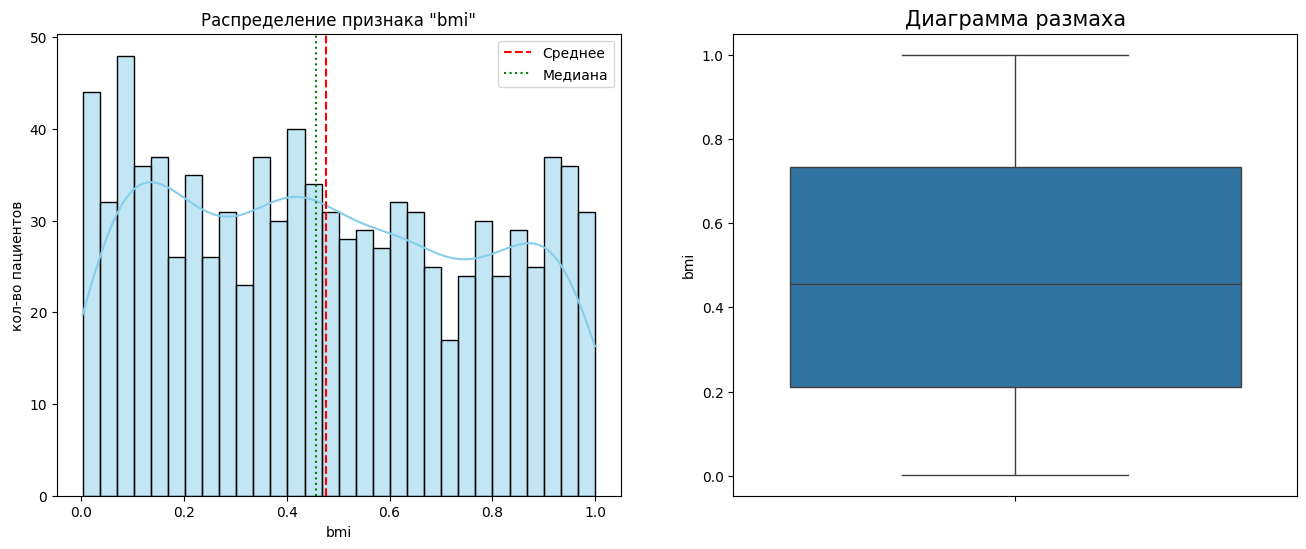

Статистика по столбцу 'triglycerides' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
triglycerides,935.00,0.49,0.29,0.00,0.24,0.47,0.73,1.00,0.47


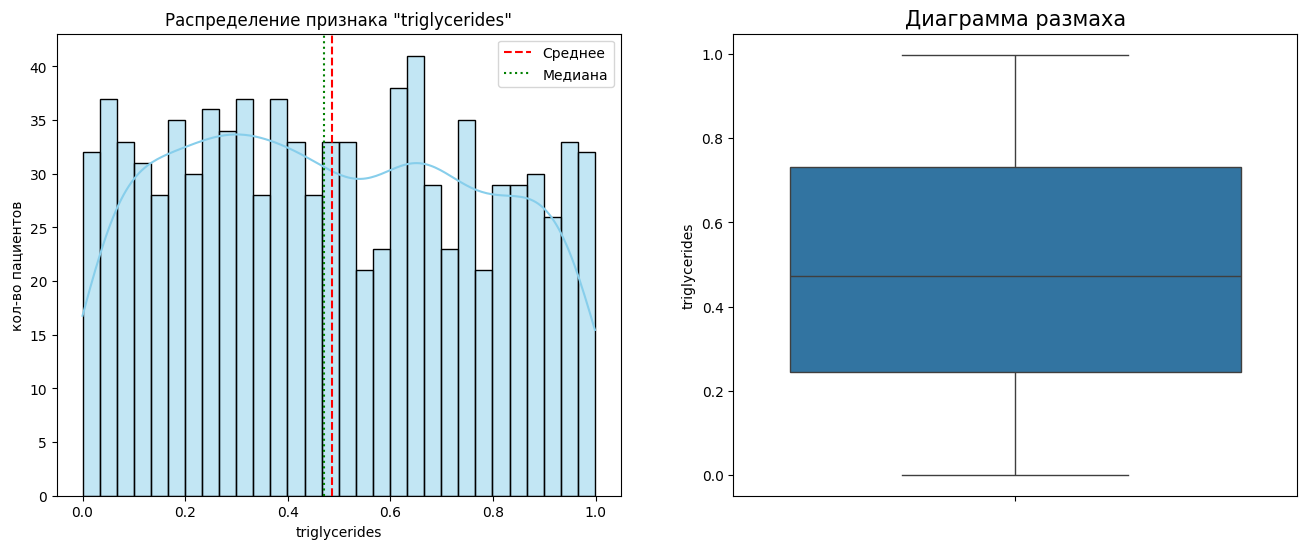

Статистика по столбцу 'sleep_hours_per_day' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
sleep_hours_per_day,935.00,0.51,0.33,0.00,0.17,0.50,0.83,1.00,0.50


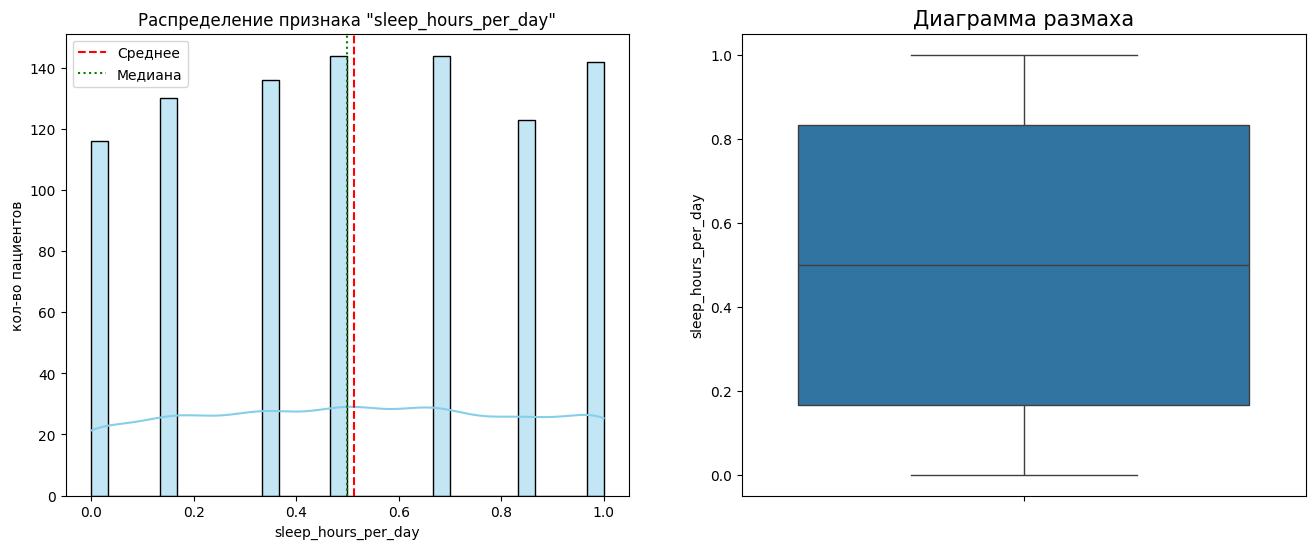

Статистика по столбцу 'blood_sugar' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
blood_sugar,935.00,0.23,0.06,0.03,0.23,0.23,0.23,0.75,0.23


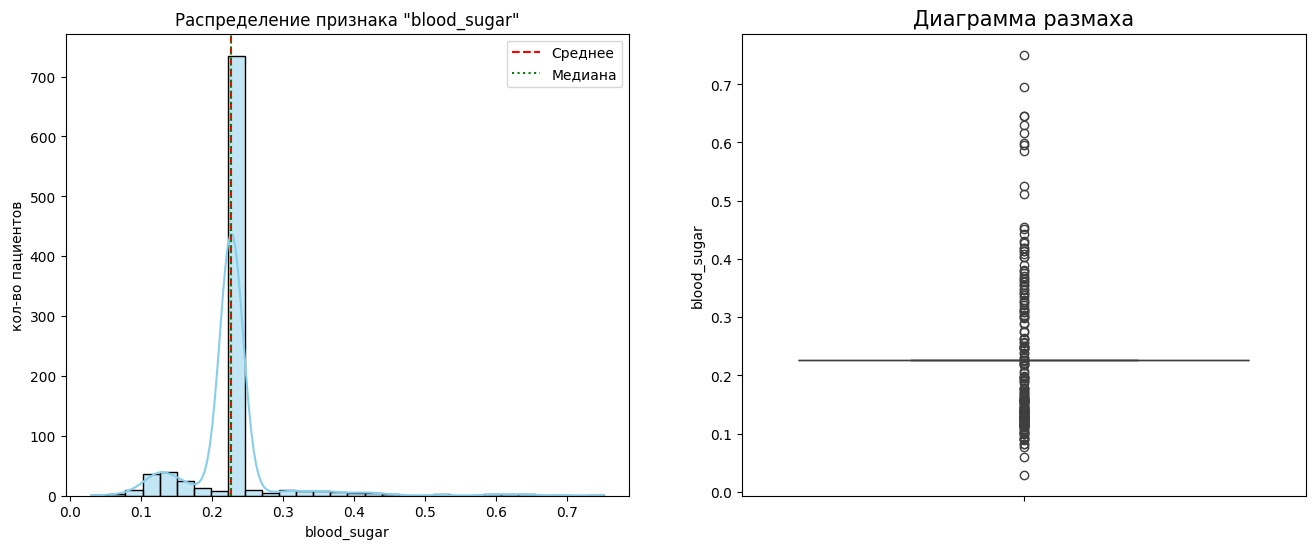

Статистика по столбцу 'ck_mb' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
ck_mb,935.00,0.05,0.07,0.00,0.05,0.05,0.05,1.00,0.05


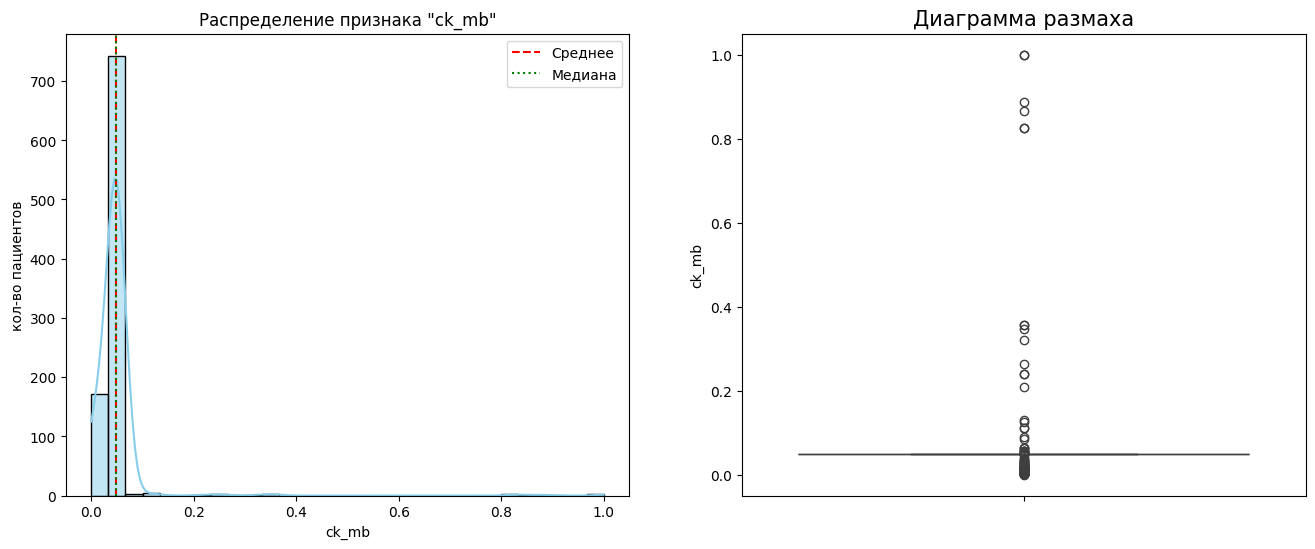

Статистика по столбцу 'troponin' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
troponin,935.00,0.03,0.04,0.00,0.04,0.04,0.04,0.97,0.04


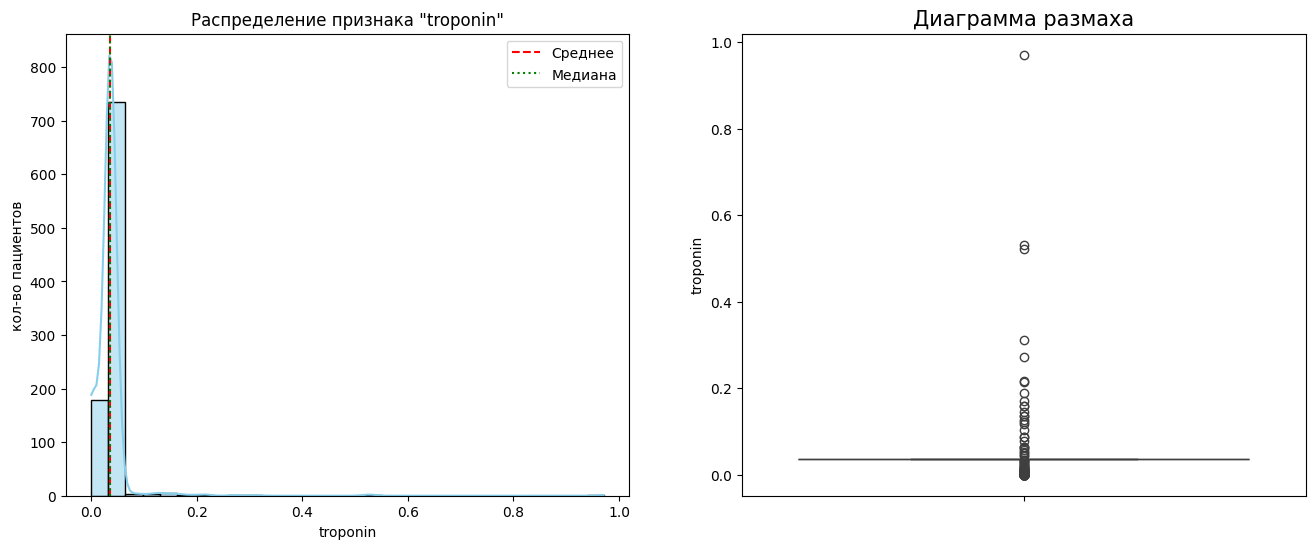

Статистика по столбцу 'systolic_blood_pressure' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
systolic_blood_pressure,935.00,0.45,0.17,0.16,0.30,0.46,0.60,0.74,0.46


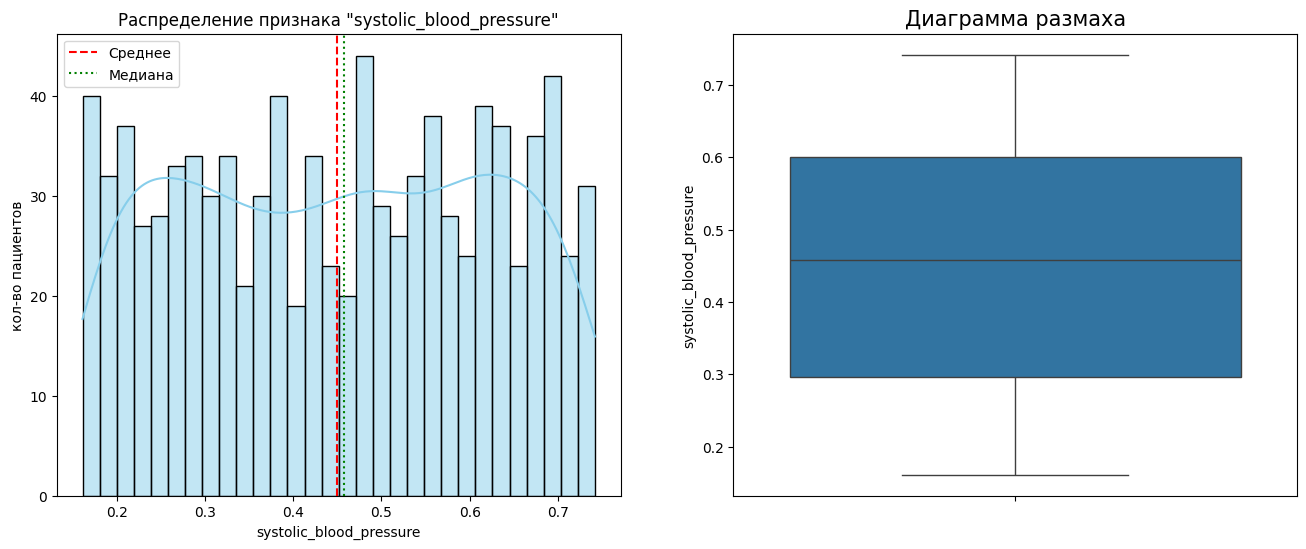

Статистика по столбцу 'diastolic_blood_pressure' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
diastolic_blood_pressure,935.00,0.50,0.17,0.21,0.35,0.50,0.65,0.79,0.50


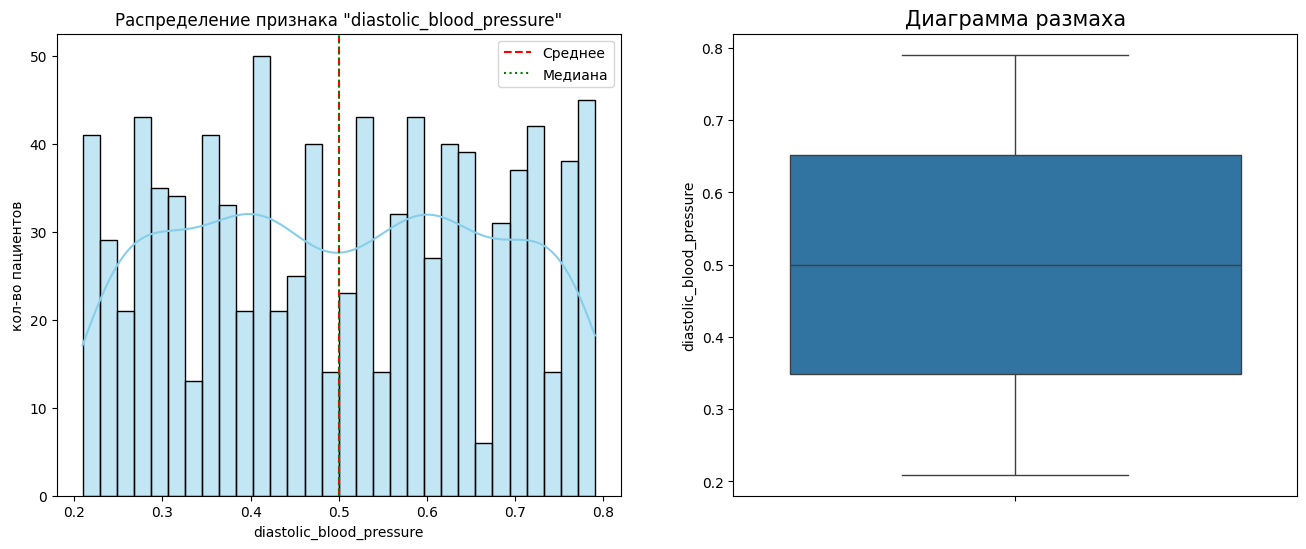


График для непрерывных количественных значений датафрейма heart_train.

Статистика по столбцу 'age' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
age,"8,442.00",0.45,0.23,0.04,0.25,0.46,0.64,0.85,0.46


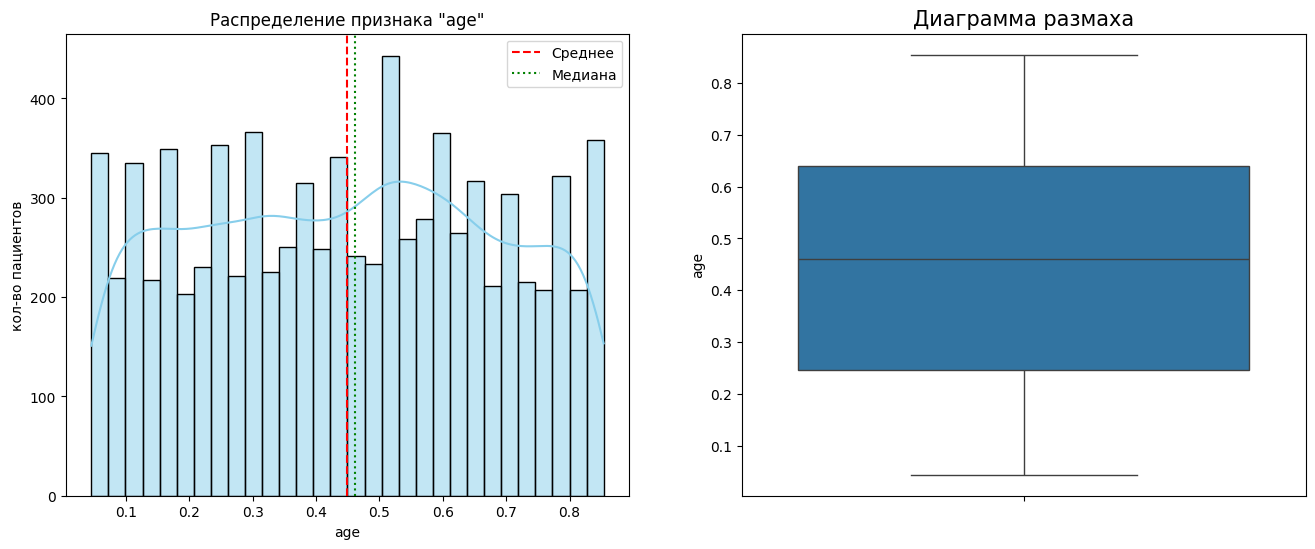

Статистика по столбцу 'cholesterol' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
cholesterol,"8,442.00",0.50,0.29,0.00,0.26,0.50,0.75,1.00,0.50


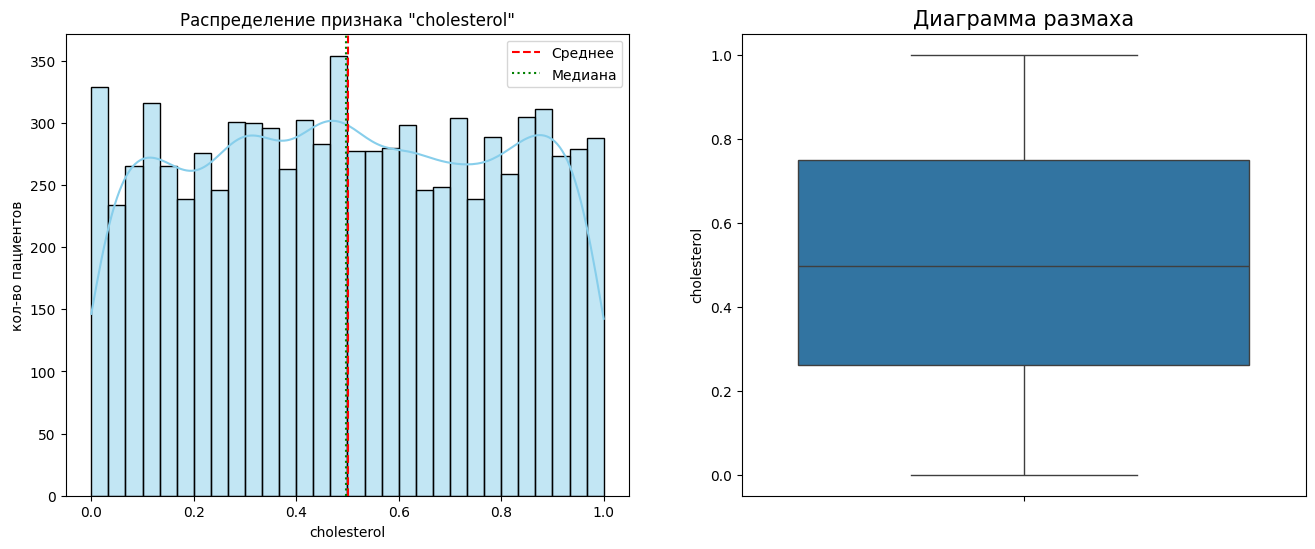

Статистика по столбцу 'heart_rate' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
heart_rate,"8,442.00",0.05,0.02,0.02,0.03,0.05,0.07,0.08,0.05


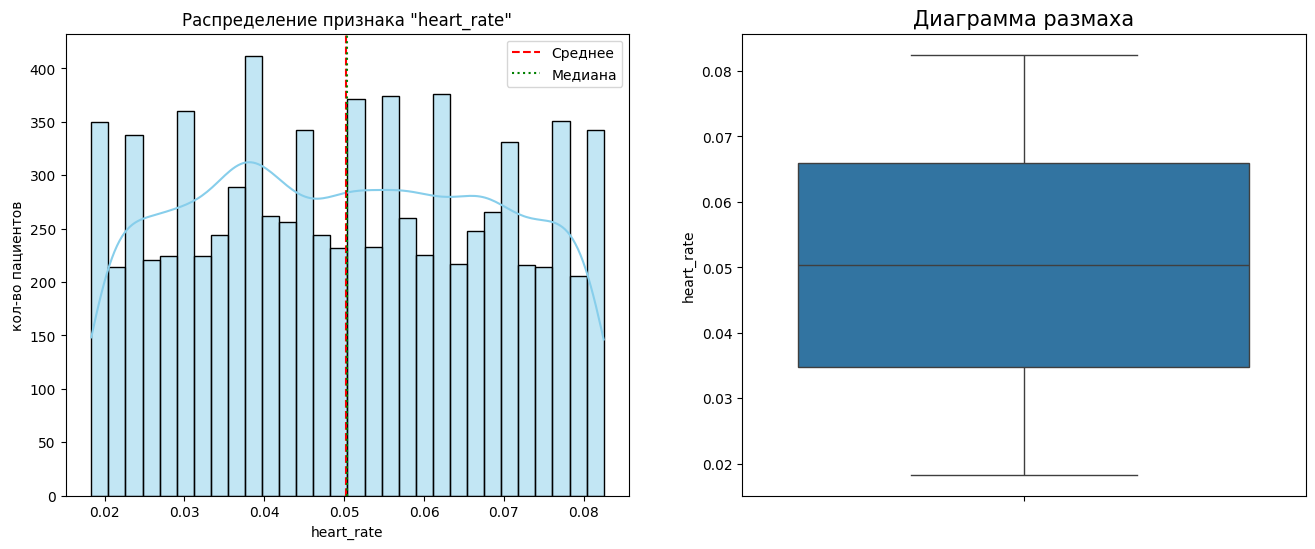

Статистика по столбцу 'exercise_hours_per_week' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
exercise_hours_per_week,"8,442.00",0.50,0.29,0.00,0.25,0.51,0.75,1.00,0.51


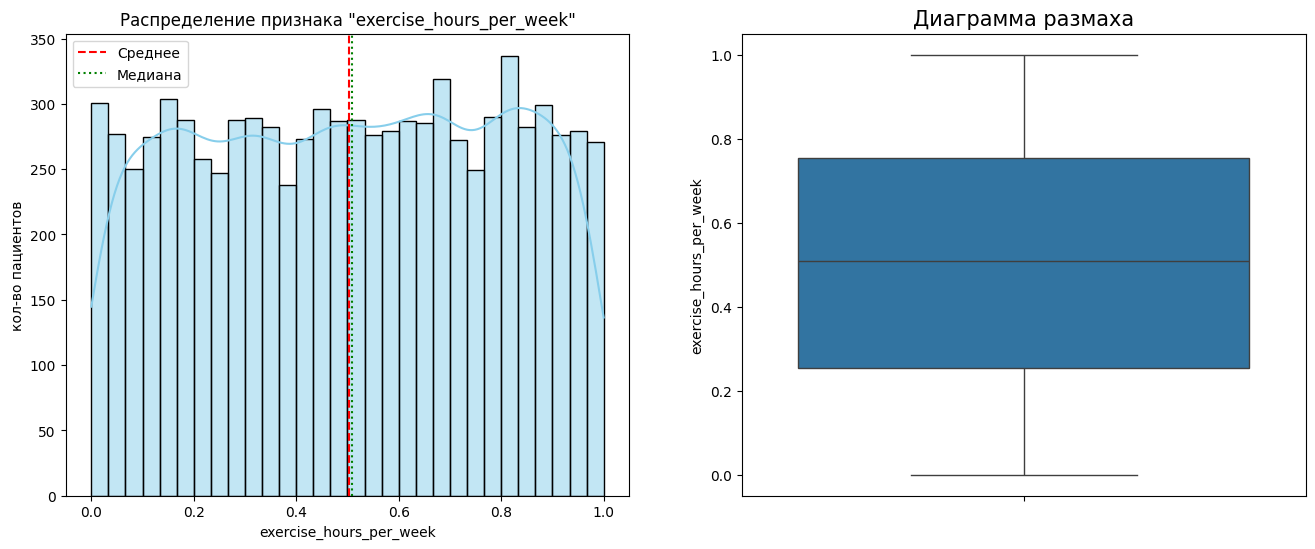

Статистика по столбцу 'sedentary_hours_per_day' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
sedentary_hours_per_day,"8,442.00",0.50,0.29,0.00,0.25,0.49,0.75,1.00,0.49


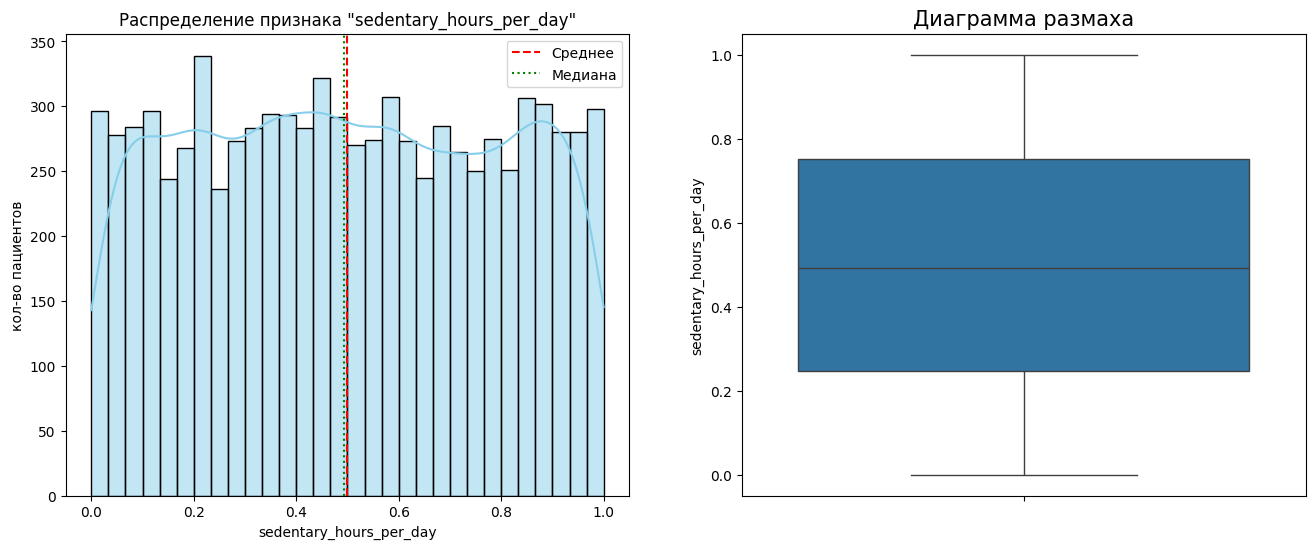

Статистика по столбцу 'income' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
income,"8,442.00",0.50,0.29,0.00,0.24,0.50,0.75,1.00,0.50


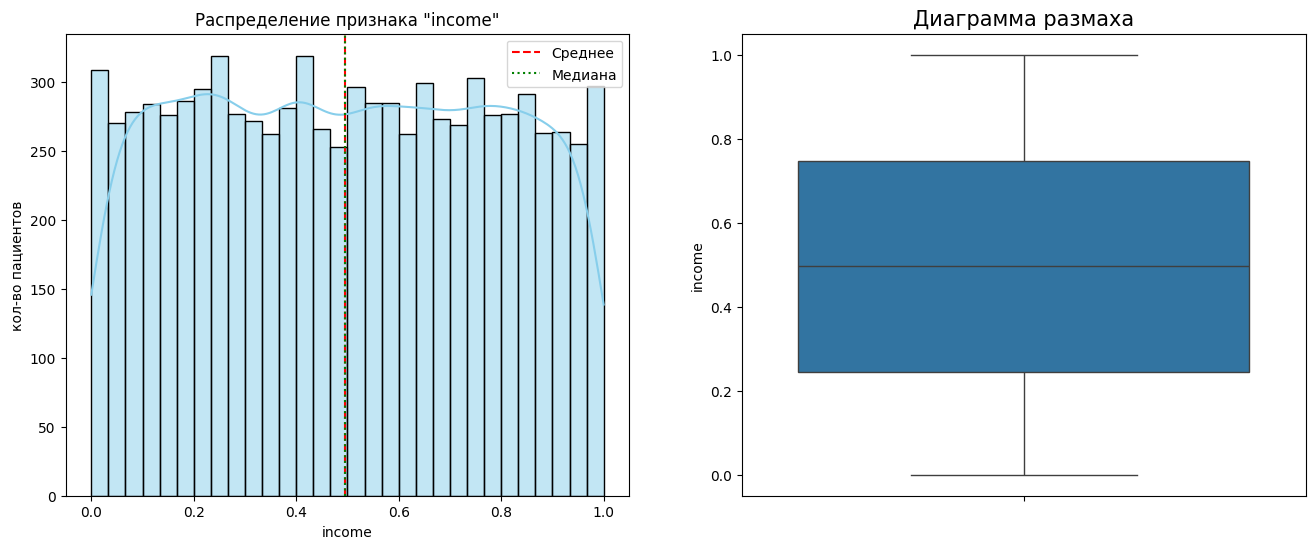

Статистика по столбцу 'bmi' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
bmi,"8,442.00",0.50,0.29,0.00,0.25,0.49,0.74,1.00,0.49


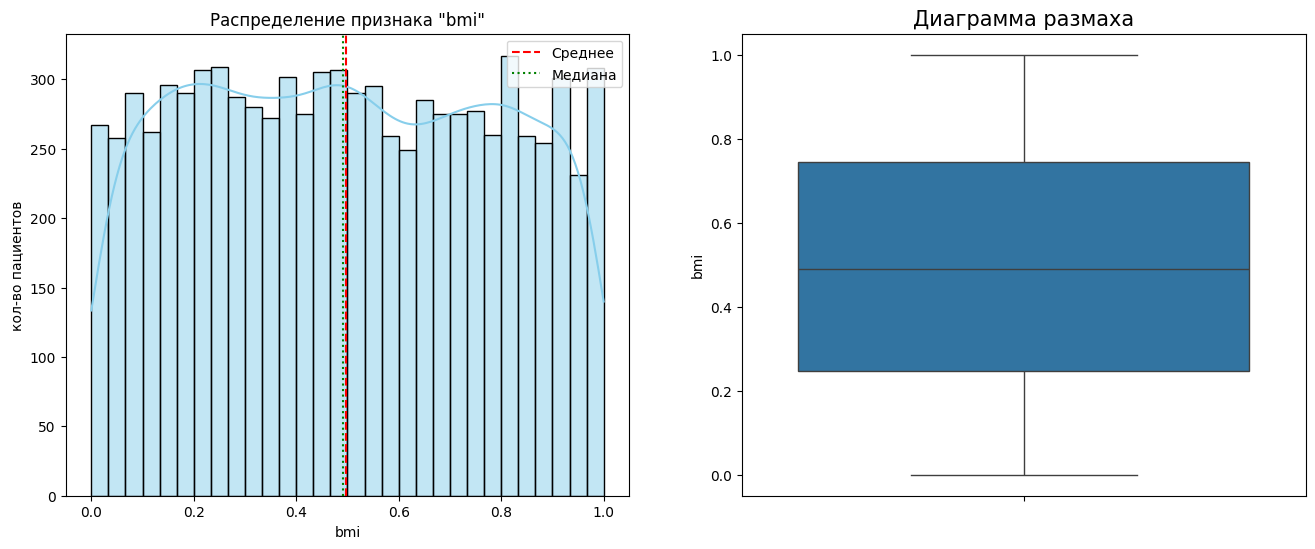

Статистика по столбцу 'triglycerides' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
triglycerides,"8,442.00",0.51,0.29,0.00,0.26,0.51,0.76,1.00,0.51


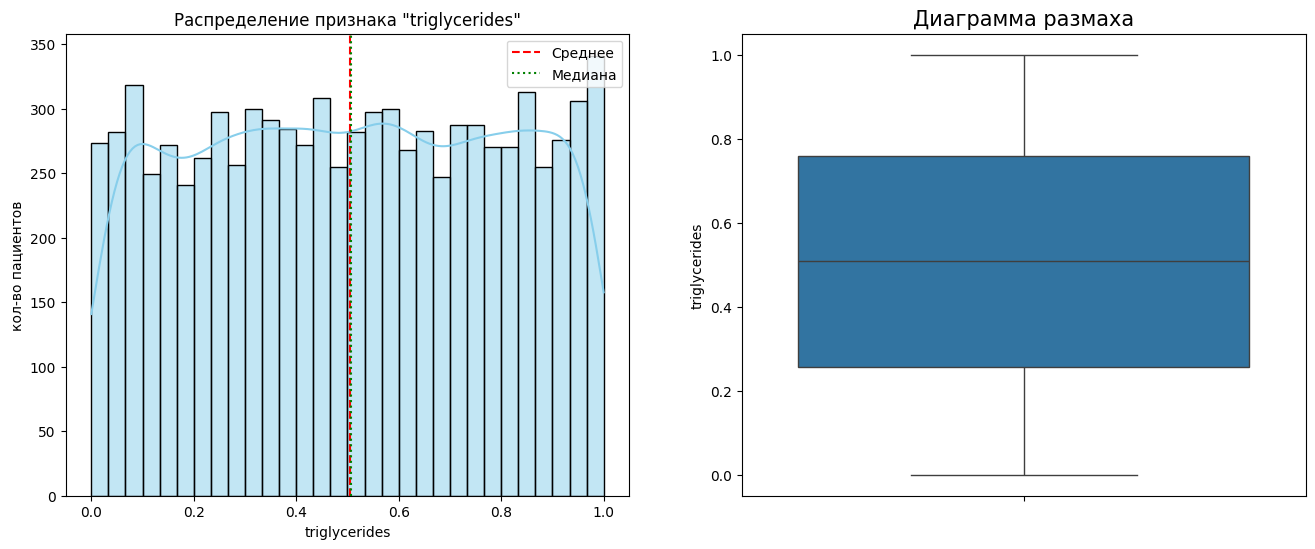

Статистика по столбцу 'sleep_hours_per_day' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
sleep_hours_per_day,"8,442.00",0.50,0.33,0.00,0.17,0.50,0.83,1.00,0.50


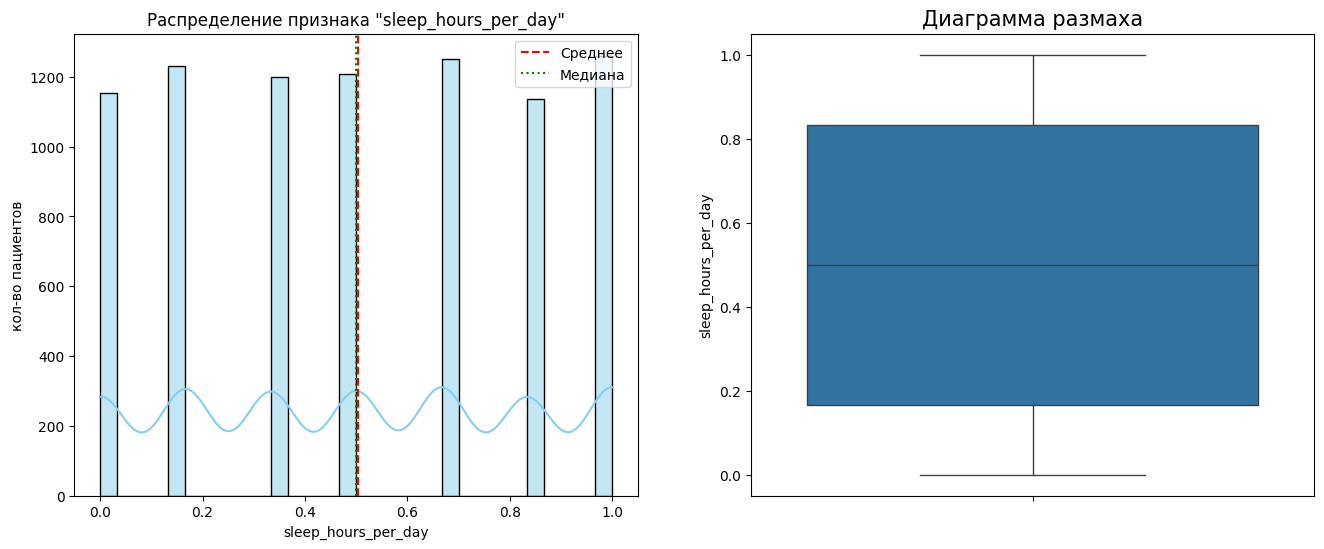

Статистика по столбцу 'heart_attack_risk_(binary)' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
heart_attack_risk_(binary),"8,442.00",0.36,0.48,0.00,0.00,0.00,1.00,1.00,0.00


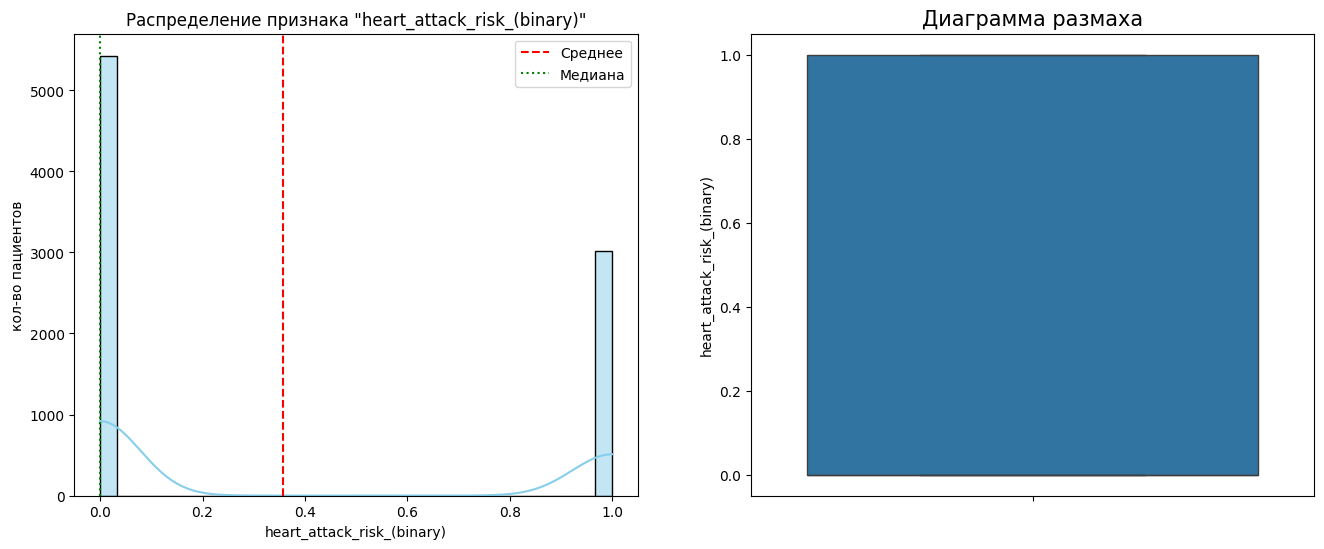

Статистика по столбцу 'blood_sugar' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
blood_sugar,"8,442.00",0.23,0.07,0.00,0.23,0.23,0.23,1.00,0.23


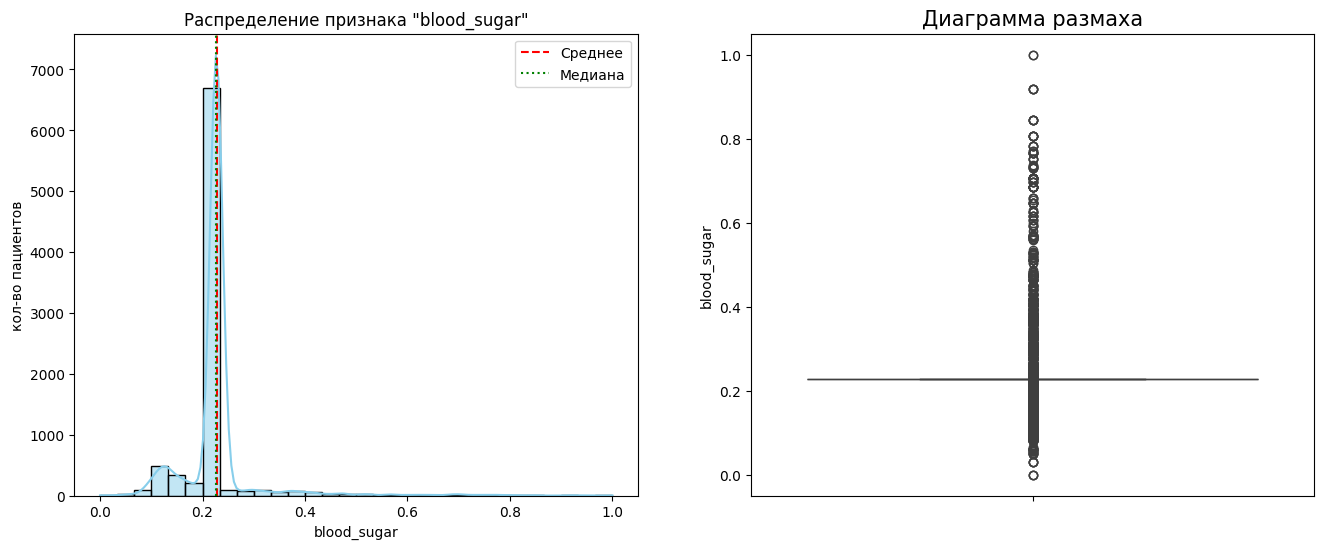

Статистика по столбцу 'ck_mb' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
ck_mb,"8,442.00",0.05,0.07,0.00,0.05,0.05,0.05,1.00,0.05


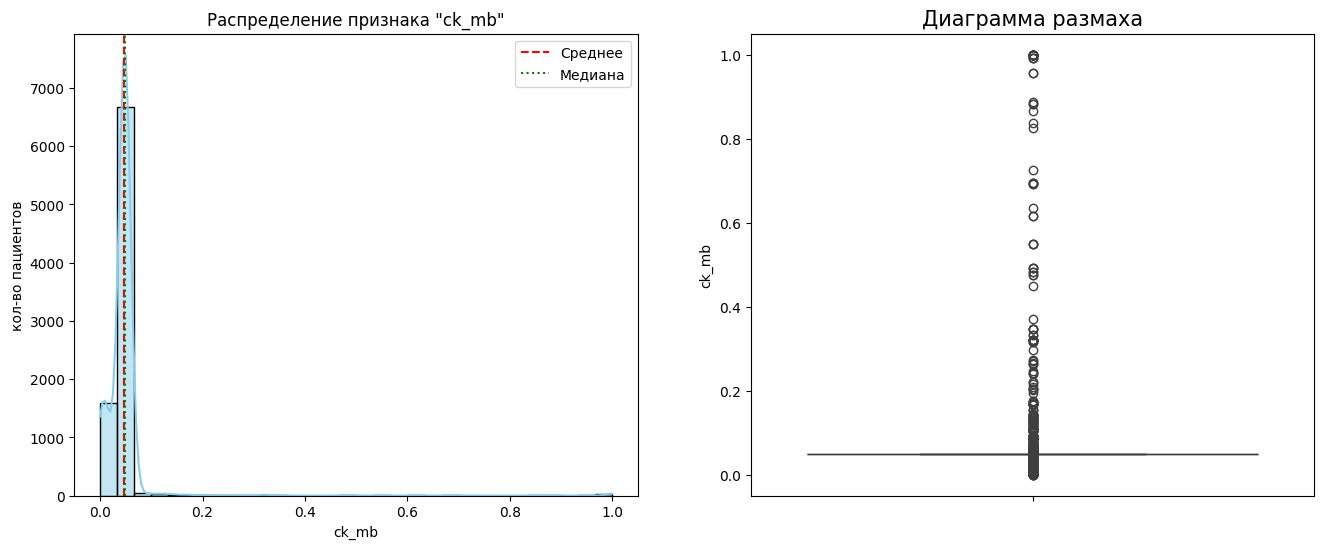

Статистика по столбцу 'troponin' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
troponin,"8,442.00",0.04,0.06,0.00,0.04,0.04,0.04,1.00,0.04


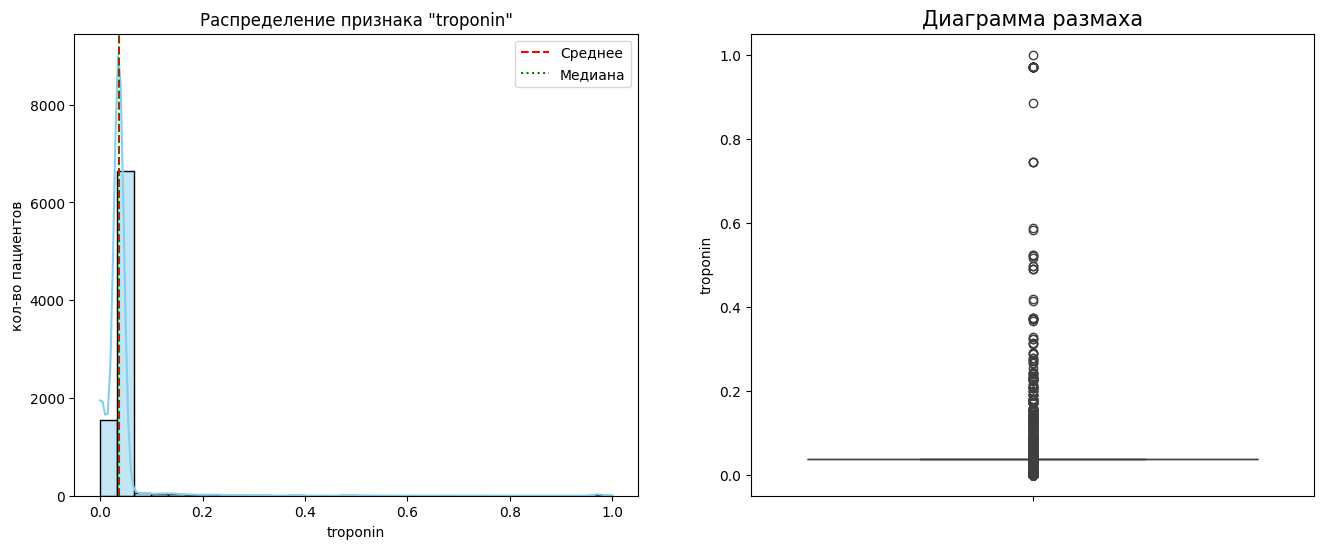

Статистика по столбцу 'systolic_blood_pressure' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
systolic_blood_pressure,"8,442.00",0.45,0.17,0.16,0.30,0.45,0.60,0.74,0.45


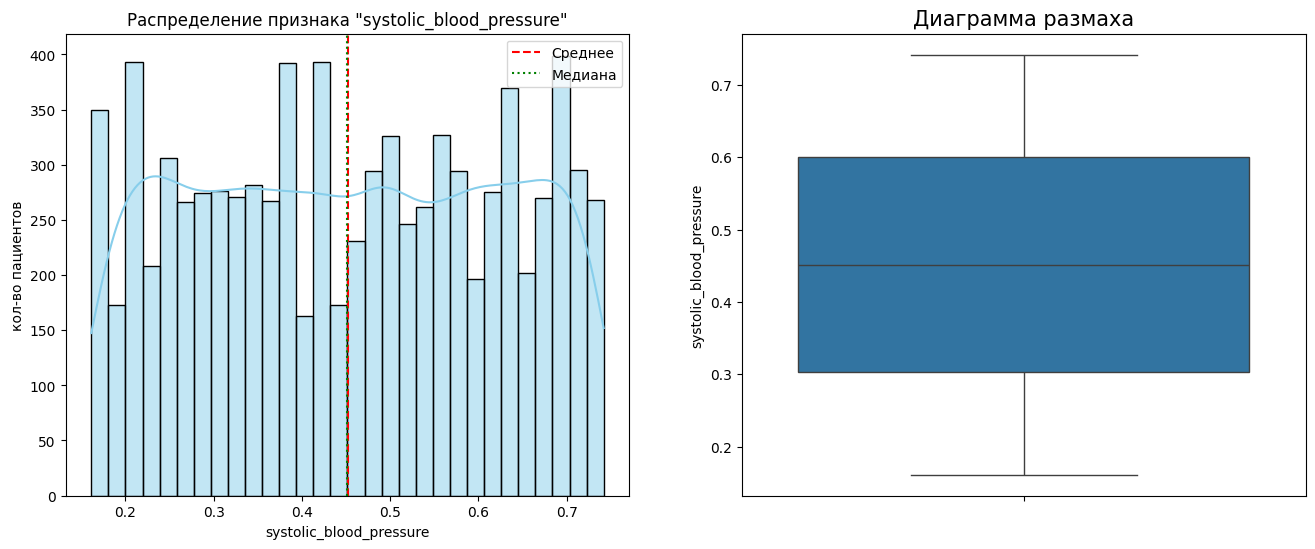

Статистика по столбцу 'diastolic_blood_pressure' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
diastolic_blood_pressure,"8,442.00",0.50,0.17,0.21,0.35,0.50,0.65,0.79,0.50


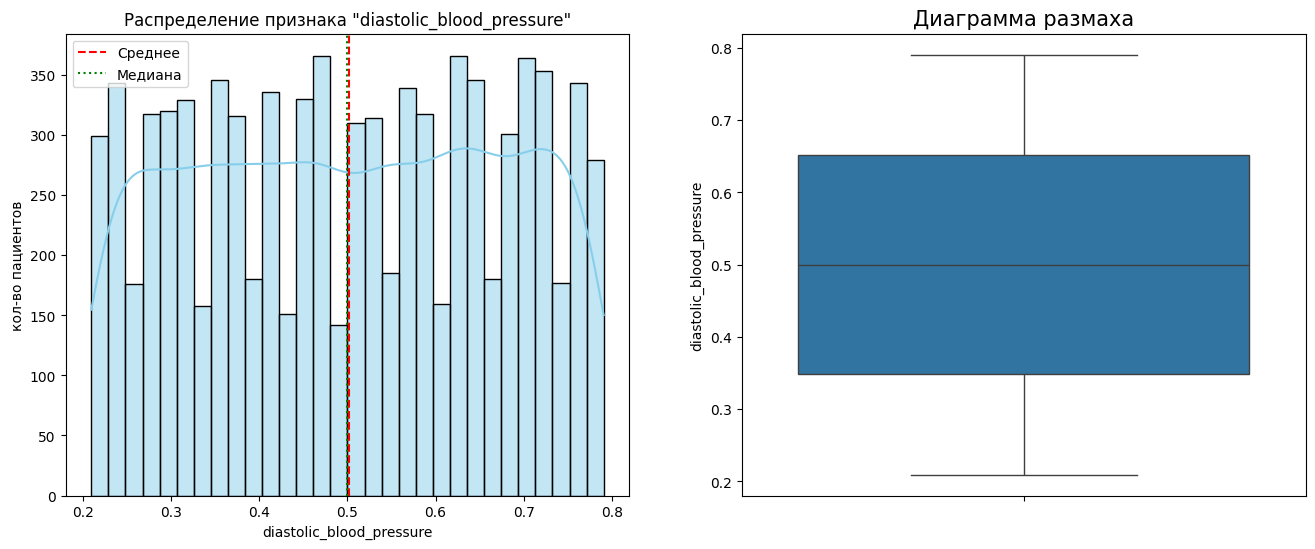

In [39]:
# Построим графики.
for name, data in data_frames.items():
    print(f'\nГрафик для непрерывных количественных значений датафрейма {name}.\n')
    custom_hist(data, name)

##### Построим графики для дискретных количественных значений датафрейма test_features.

In [40]:
 # Кастомный метод для построения гистограммы для дискретных признаков.
def custom_count_plot(df, df_name, add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во пациентов'
    columns = df.drop(columns=del_columns).select_dtypes(include=['int64', 'Int64', 'object']).columns.to_list()
    columns.extend(add_columns)
    
    # Создаем временный DataFrame без NA значений для построения графика.
    pdf = df.dropna().copy()

    for column in columns:

        stats_column(value=df, column=column, text=f'датафрейма {df_name}', is_sum=False)
        plt.figure(figsize=(8, 4))

        sns.countplot(x=column, data=pdf, color='skyblue', edgecolor='black')
        plt.axvline(pdf[column].mean(), color='red', linestyle='--', label='Среднее')
        plt.axvline(pdf[column].median(), color='green', linestyle=':', label='Медиана')
        plt.title(f'Распределение признака "{column}"')
        plt.ylabel(ylabel)
        plt.legend()

        plt.show()

In [41]:
# Кастомный метод для построения гистограммы и диаграммы размаха.
def custom_hist(df, df_name, add_columns=[], del_columns=[ID]):
    ylabel = 'кол-во пациентов'
    columns = df.drop(columns=del_columns).select_dtypes(include=['float64', 'int64']).columns.to_list()
    columns.extend(add_columns)

    for column in columns:
        stats_column(value=df, column=column, text=f'датафрейма {df_name}', is_sum=False)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

        sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black', ax=ax[ZERO])

        # Добавляем линии среднего и медианы (только для числовых данных)
        if pd.api.types.is_numeric_dtype(pdf[column]):
            ax[ZERO].axvline(df[column].mean(), color='red', linestyle='--', label='Среднее')
            ax[ZERO].axvline(df[column].median(), color='green', linestyle=':', label='Медиана')

        ax[ZERO].set_title(f'Распределение признака "{column}"')
        ax[ZERO].set_ylabel(ylabel)
        ax[ZERO].legend()

        sns.boxplot(df[column], ax=ax[ONE])
        ax[ONE].set_title('Диаграмма размаха', fontsize=15)
        ax[ONE].set_xlabel(None)

        plt.show()


График для дискретных количественных значений датафрейма heart_test.

Статистика по столбцу 'diabetes' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
diabetes,935.00,0.66,0.48,0.00,0.00,1.00,1.00,1.00,1.00


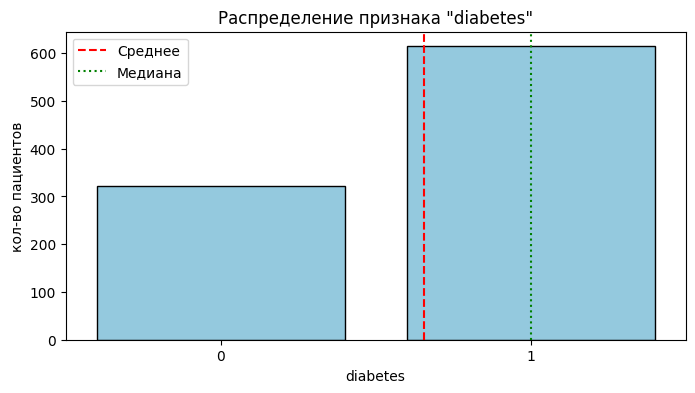

Статистика по столбцу 'family_history' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
family_history,935.00,0.48,0.50,0.00,0.00,0.00,1.00,1.00,0.00


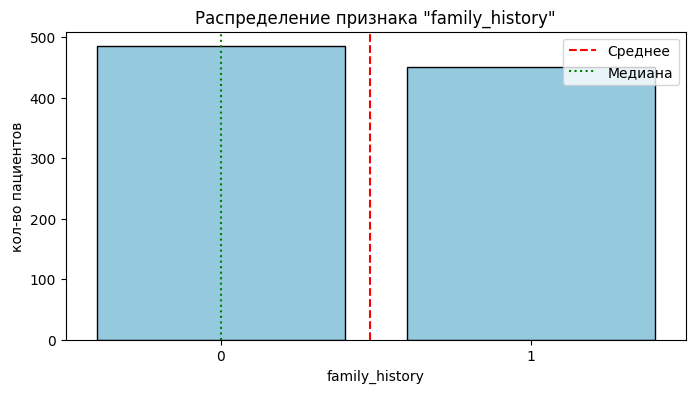

Статистика по столбцу 'smoking' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
smoking,935.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00,1.00


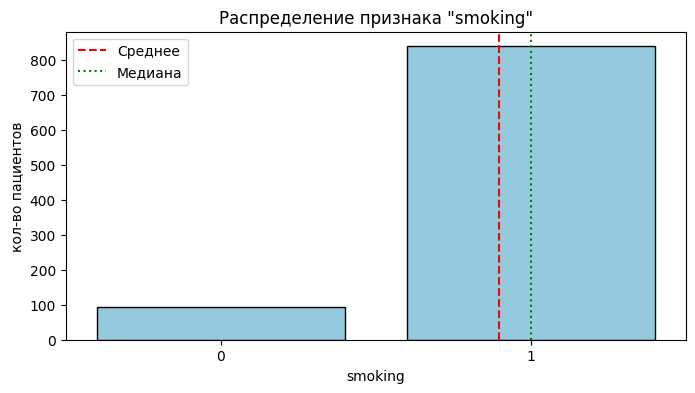

Статистика по столбцу 'obesity' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
obesity,935.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00,1.00


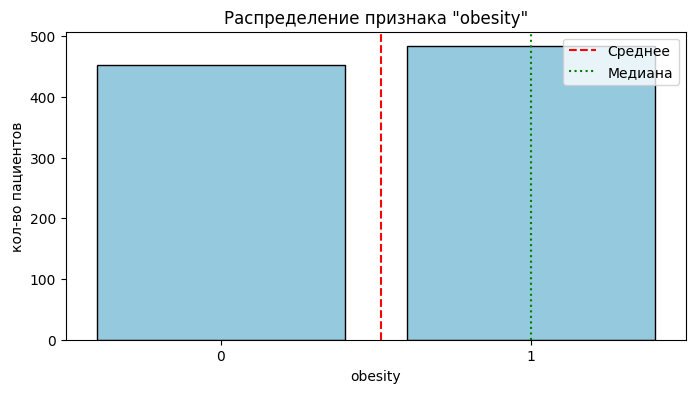

Статистика по столбцу 'alcohol_consumption' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
alcohol_consumption,935.00,0.58,0.49,0.00,0.00,1.00,1.00,1.00,1.00


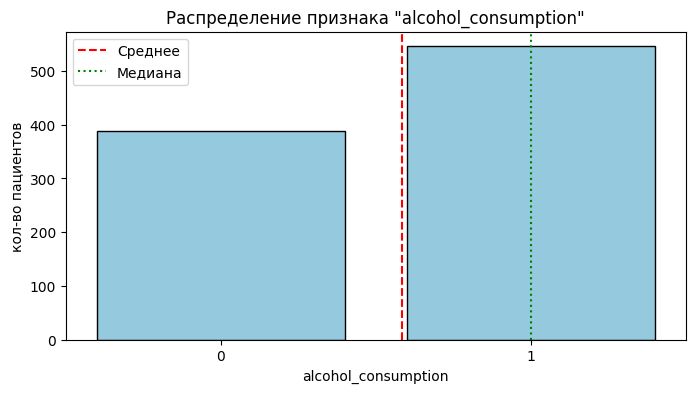

Статистика по столбцу 'diet' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
diet,935.00,0.99,0.82,0.00,0.00,1.00,2.00,2.00,1.00


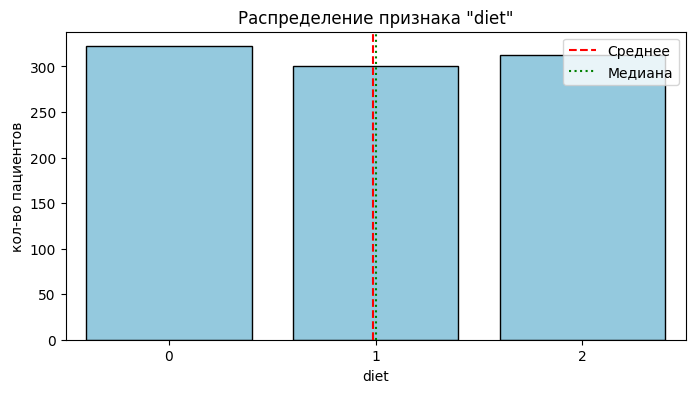

Статистика по столбцу 'previous_heart_problems' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
previous_heart_problems,935.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00,0.00


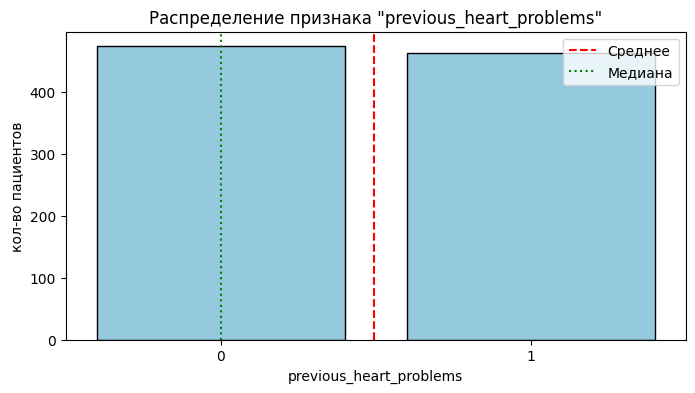

Статистика по столбцу 'medication_use' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
medication_use,935.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00,0.00


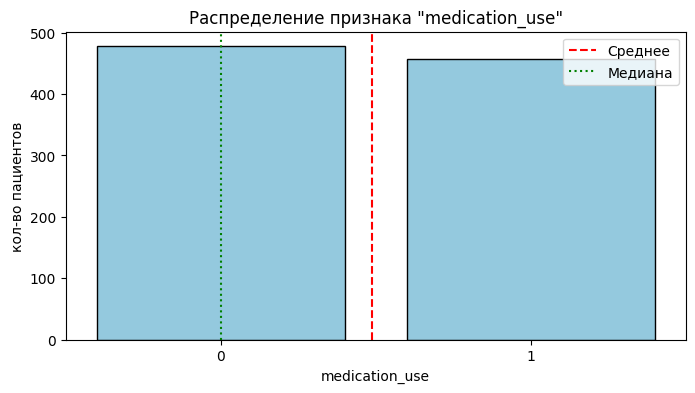

Статистика по столбцу 'stress_level' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
stress_level,935.00,5.33,2.86,1.00,3.00,5.00,8.00,10.00,5.00


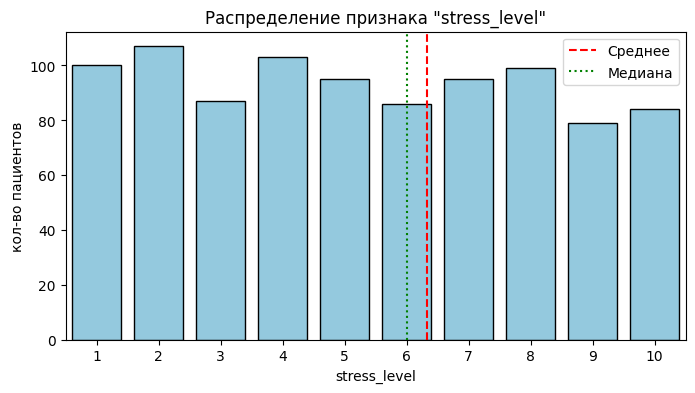

Статистика по столбцу 'physical_activity_days_per_week' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
physical_activity_days_per_week,935.00,3.44,2.30,0.00,1.00,3.00,5.00,7.00,3.00


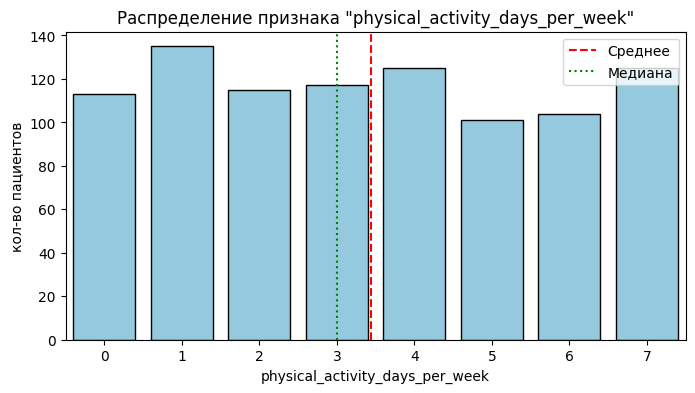

Статистика по столбцу 'gender' датафрейма heart_test:


,count,mean,std,min,25%,50%,75%,max,median
gender,935.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00,1.00


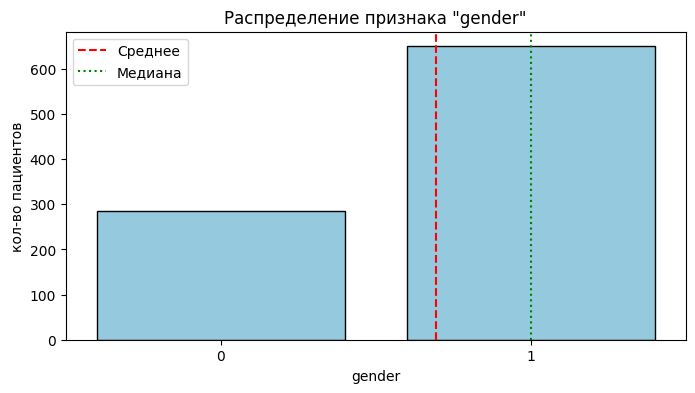


График для дискретных количественных значений датафрейма heart_train.

Статистика по столбцу 'diabetes' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
diabetes,"8,442.00",0.65,0.48,0.00,0.00,1.00,1.00,1.00,1.00


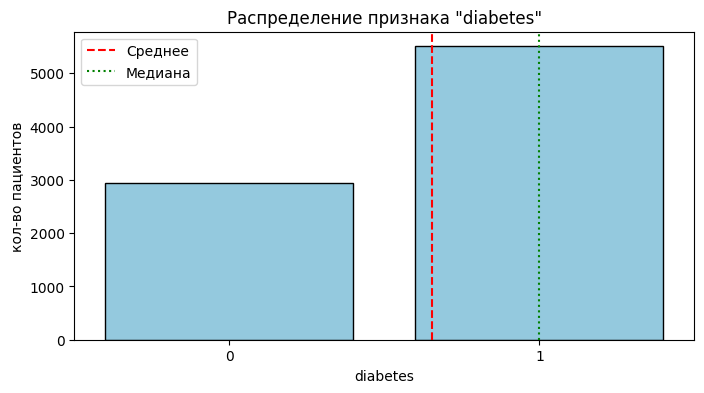

Статистика по столбцу 'family_history' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
family_history,"8,442.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00,0.00


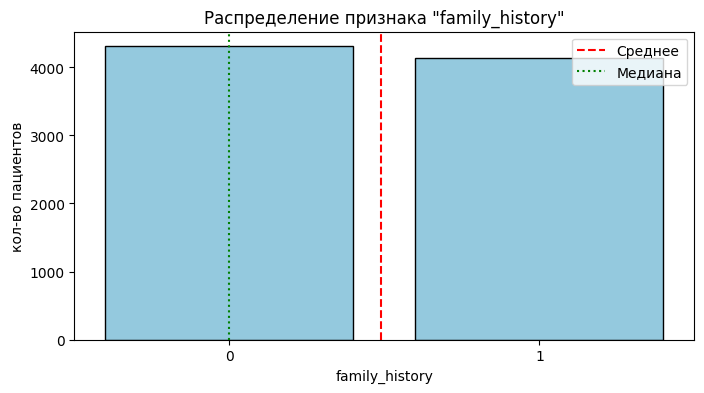

Статистика по столбцу 'smoking' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
smoking,"8,442.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00,1.00


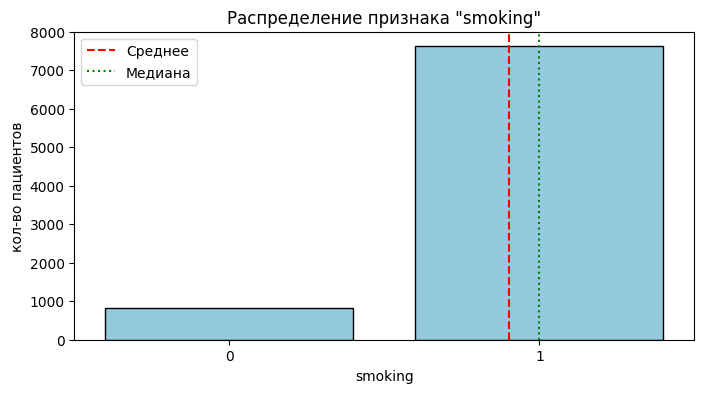

Статистика по столбцу 'obesity' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
obesity,"8,442.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00,0.00


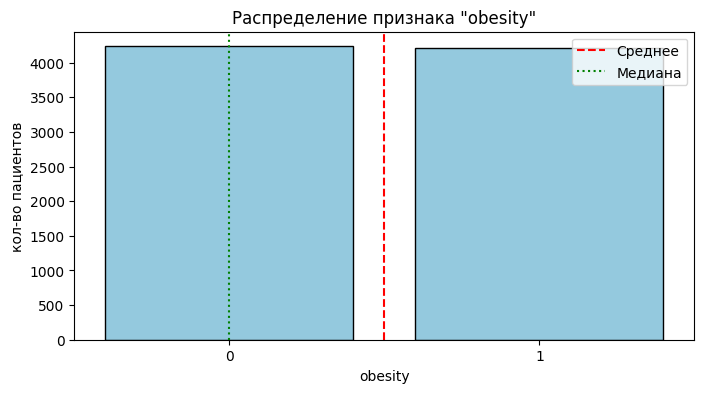

Статистика по столбцу 'alcohol_consumption' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
alcohol_consumption,"8,442.00",0.60,0.49,0.00,0.00,1.00,1.00,1.00,1.00


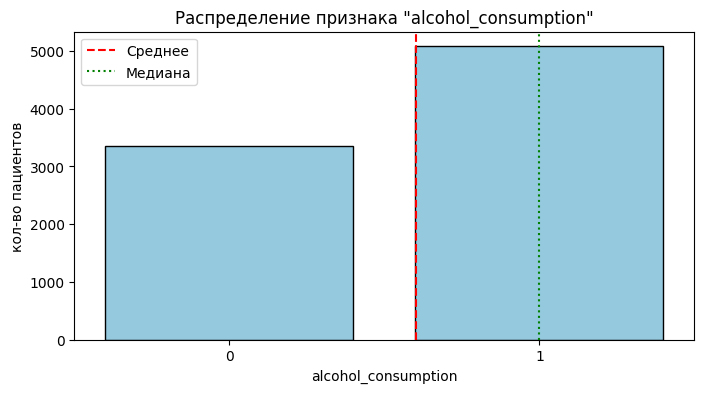

Статистика по столбцу 'diet' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
diet,"8,442.00",1.00,0.81,0.00,0.00,1.00,2.00,2.00,1.00


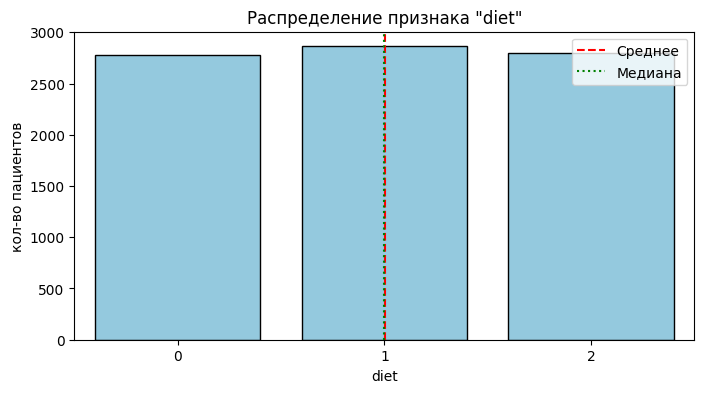

Статистика по столбцу 'previous_heart_problems' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
previous_heart_problems,"8,442.00",0.50,0.50,0.00,0.00,0.00,1.00,1.00,0.00


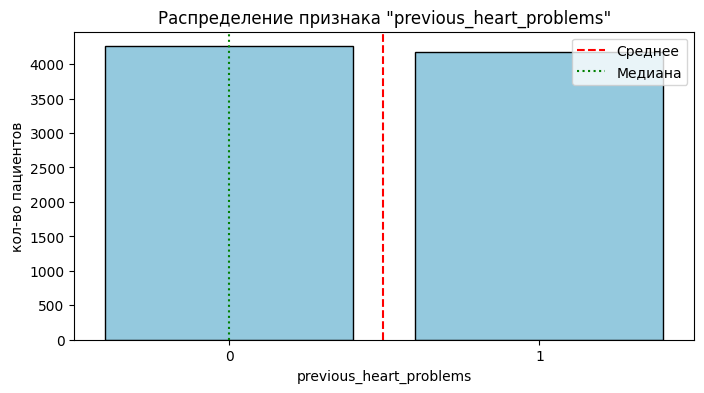

Статистика по столбцу 'medication_use' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
medication_use,"8,442.00",0.50,0.50,0.00,0.00,1.00,1.00,1.00,1.00


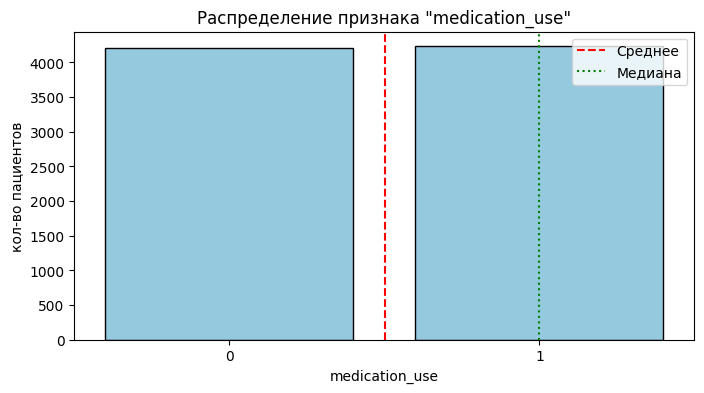

Статистика по столбцу 'stress_level' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
stress_level,"8,442.00",5.49,2.87,1.00,3.00,5.00,8.00,10.00,5.00


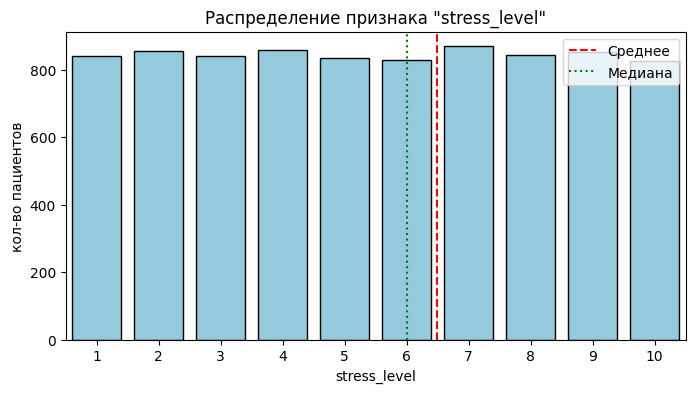

Статистика по столбцу 'physical_activity_days_per_week' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
physical_activity_days_per_week,"8,442.00",3.51,2.28,0.00,2.00,3.00,6.00,7.00,3.00


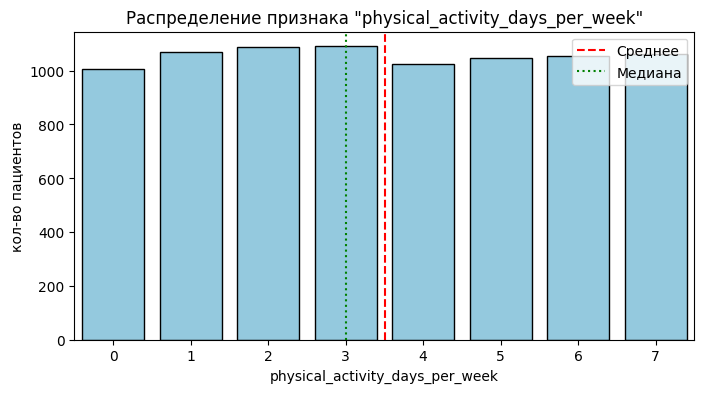

Статистика по столбцу 'gender' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
gender,"8,442.00",0.70,0.46,0.00,0.00,1.00,1.00,1.00,1.00


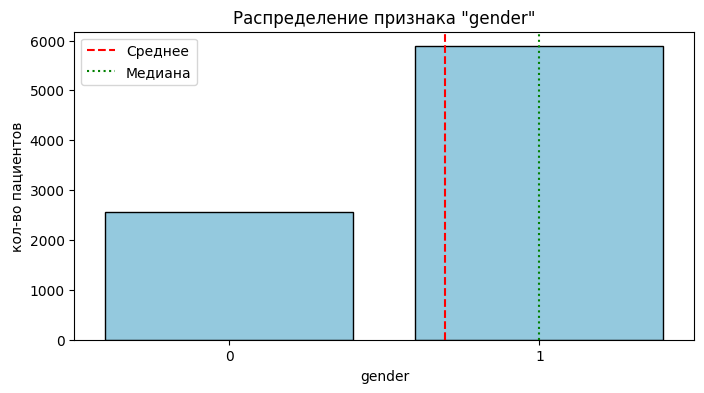

Статистика по столбцу 'heart_attack_risk_(binary)' датафрейма heart_train:


,count,mean,std,min,25%,50%,75%,max,median
heart_attack_risk_(binary),"8,442.00",0.36,0.48,0.00,0.00,0.00,1.00,1.00,0.00


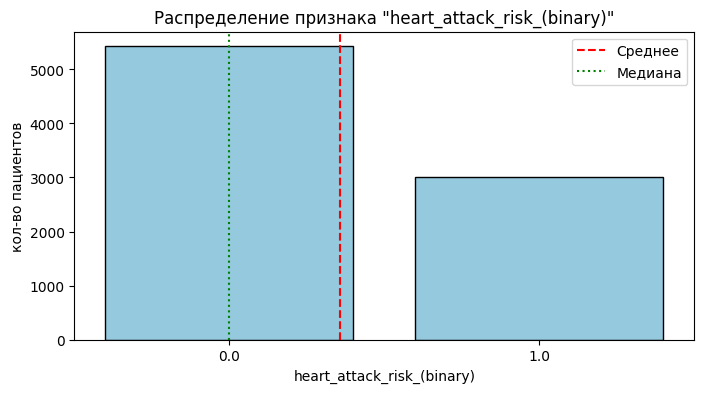

In [42]:
for name, data in data_frames.items():
    print(f'\nГрафик для дискретных количественных значений датафрейма {name}.\n')
    add_columns=[]
    if name == 'heart_train':
        add_columns=[target_attribute]
    custom_count_plot(data, name, add_columns=add_columns)

## Корреляционный анализ

### Рассчет коэффициентов корреляции.

In [43]:
# Отобразим список передаваемых непрерывных признаков.
display(num_columns)

['age',
 'bmi',
 'income',
 'cholesterol',
 'blood_sugar',
 'triglycerides',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
 'heart_rate',
 'ck_mb',
 'troponin',
 'exercise_hours_per_week',
 'sedentary_hours_per_day',
 'sleep_hours_per_day']

Проверим линейную связь между признаками с помощью матрицы корреляции.<br/>
Для модели линейной регрессии линейная зависимость между целевыми и входными признаками обязательна, иначе предсказания будут ошибочными.

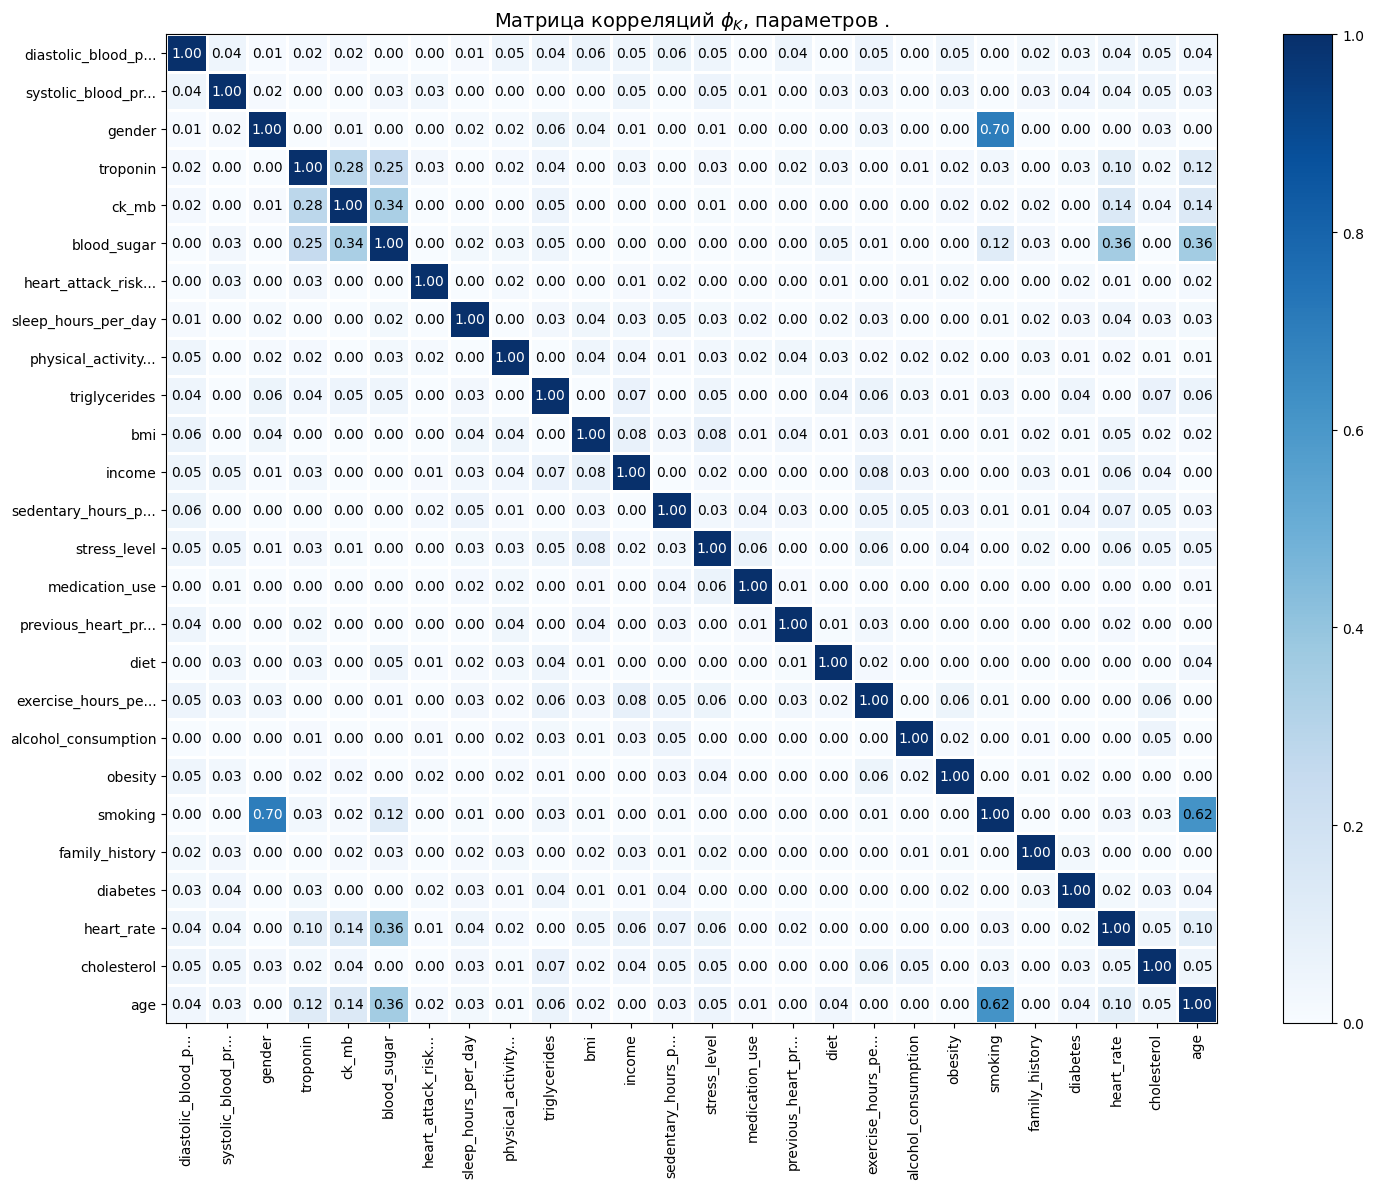

In [44]:
# Матрица корреляций.
result = heart_train.drop(columns=ID)
phik_overview = phik_matrix(result, interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0.000, color_map=COLOR_FOUR,
    title=r'Матрица корреляций $\phi_K$, параметров .',
    fontsize_factor=1.0,
    figsize=(15, 12)
)

In [45]:
display(phik_overview[target_attribute]
        .to_frame()
        .sort_values(target_attribute, ascending=False))

,heart_attack_risk_(binary)
heart_attack_risk_(binary),1.00
systolic_blood_pressure,0.03
troponin,0.03
age,0.02
sedentary_hours_per_day,0.02
diabetes,0.02
physical_activity_days_per_week,0.02
obesity,0.02
alcohol_consumption,0.01
income,0.01


Мультиколлинеарности между входными признаками датафрейма heart_train нет.<br/>
Наблюдаем очень слабую зависимость, либо ее отсутствие между входными признаками и таргетом.

### Подготовка данных.

Удалим идентификатор пациента 'id' и проверим датафрейм на явное дублирование данных.

In [46]:
print(f'Количество явных дубликатов в датафрейме heart_train - ', end='')
print(heart_train.drop([ID], axis=1).duplicated().sum());
custom_info(heart_train)

Количество явных дубликатов в датафрейме heart_train - 0


,non_null_count,dtype
age,8442,float64
cholesterol,8442,float64
heart_rate,8442,float64
diabetes,8442,int64
family_history,8442,int64
smoking,8442,int64
obesity,8442,int64
alcohol_consumption,8442,int64
exercise_hours_per_week,8442,float64
diet,8442,int64


Количество записей: 8442
Количество столбцов: 27


In [47]:
# Составим список бинарных полей.
ord_columns = ['diabetes',
               'gender',
               'smoking',
               'alcohol_consumption',
               'family_history',
               'obesity',
               'previous_heart_problems',
               'medication_use',
               'physical_activity_days_per_week'
               ]
display(ord_columns)

['diabetes',
 'gender',
 'smoking',
 'alcohol_consumption',
 'family_history',
 'obesity',
 'previous_heart_problems',
 'medication_use',
 'physical_activity_days_per_week']

In [48]:
columns_exclude = [# 'diabetes',
                  # 'gender',
                  # 'smoking',
                  # 'alcohol_consumption',
                  # 'previous_heart_problems',
                  # 'medication_use'
                  # 'diet',
                  # 'sleep_hours_per_day'
                 ]

In [49]:
# Составим список числовых полей.
num_columns = ['age',
               'bmi',
               'income',
               'cholesterol',
               'blood_sugar',
               'triglycerides',
               'systolic_blood_pressure',
               'diastolic_blood_pressure',
               'heart_rate',
               'ck_mb',
               'troponin',
               'exercise_hours_per_week',
               'sedentary_hours_per_day',
               'sleep_hours_per_day'
               ]
display(num_columns)

['age',
 'bmi',
 'income',
 'cholesterol',
 'blood_sugar',
 'triglycerides',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
 'heart_rate',
 'ck_mb',
 'troponin',
 'exercise_hours_per_week',
 'sedentary_hours_per_day',
 'sleep_hours_per_day']

In [50]:
# Составим список категориальных полей.
ohe_columns = ['diet',
               'stress_level'
               ]
display(ohe_columns)

['diet', 'stress_level']

In [51]:
# Методы подготовки данных.
def prepare_data(data_frame, columns_exclude=[], target_attribute=target_attribute):

    # Подготовим данные датасета.
    data_frame = data_frame.drop(columns=columns_exclude).copy()

    # Делим данные на входные и целевые.
    X = data_frame.drop(target_attribute, axis=1)
    y = data_frame[target_attribute]

    # Делим данные на тренировочные и тестовые.
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE,
        stratify = data_frame[target_attribute]
    )
    
    # Сохраним последовательность полей тренировочной выборки до масштабирования.
    column_before = X_train.columns.to_list()

    return X_train, X_test, y_train, y_test, column_before

In [52]:
# Подготовим данные.
X_train, X_test, y_train, y_test, column_before = prepare_data(heart_train) # , columns_exclude=columns_exclude

In [53]:
# Выведем статистику по столбцам.
print('\nСтатистика по тренировочной выборке X_train.')
custom_info(X_train)
print('\nСтатистика по тестовой выборке X_test.')
custom_info(X_test, is_result=False)


Статистика по тренировочной выборке X_train.


,non_null_count,dtype
age,6331,float64
cholesterol,6331,float64
heart_rate,6331,float64
diabetes,6331,int64
family_history,6331,int64
smoking,6331,int64
obesity,6331,int64
alcohol_consumption,6331,int64
exercise_hours_per_week,6331,float64
diet,6331,int64


Количество записей: 6331
Количество столбцов: 26

Статистика по тестовой выборке X_test.
Количество записей: 2111
Количество столбцов: 26


In [54]:
custom_info(X_test)

,non_null_count,dtype
age,2111,float64
cholesterol,2111,float64
heart_rate,2111,float64
diabetes,2111,int64
family_history,2111,int64
smoking,2111,int64
obesity,2111,int64
alcohol_consumption,2111,int64
exercise_hours_per_week,2111,float64
diet,2111,int64


Количество записей: 2111
Количество столбцов: 26


In [55]:
display(num_columns)

['age',
 'bmi',
 'income',
 'cholesterol',
 'blood_sugar',
 'triglycerides',
 'systolic_blood_pressure',
 'diastolic_blood_pressure',
 'heart_rate',
 'ck_mb',
 'troponin',
 'exercise_hours_per_week',
 'sedentary_hours_per_day',
 'sleep_hours_per_day']

In [56]:
display(ord_columns)

['diabetes',
 'gender',
 'smoking',
 'alcohol_consumption',
 'family_history',
 'obesity',
 'previous_heart_problems',
 'medication_use',
 'physical_activity_days_per_week']

In [57]:
display(ohe_columns)

['diet', 'stress_level']

Количественные и категориальные признаки обработаем в пайплайне раздельно.

In [58]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
def ohe_pipe():
    return Pipeline(
        [('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')), # missing_values=np.nan, 
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])
#         ('simpleImputer_ohe_two', SimpleImputer(missing_values=pd.NA, strategy='most_frequent'))])

ohe_pipe_one = ohe_pipe()

In [59]:
# Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков SimpleImputer
def ord_pipe():
    return Pipeline([('simpleImputer_ord', SimpleImputer(strategy='most_frequent'))])

#        [('simpleImputer_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#         ('simpleImputer_ord_two', SimpleImputer(missing_values=pd.NA, strategy='most_frequent'))])

ord_pipe_one = ord_pipe()

In [60]:
# Создаём пайплайн для подготовки признаков из списка num_columns: заполнение пропусков SimpleImputer
def num_pipe():
    return Pipeline(
        [('simpleImputer_num', SimpleImputer(strategy='median')),
         ('scaler', MinMaxScaler())])

num_pipe_one = num_pipe()

In [61]:
# Создаём общий пайплайн для подготовки данных.
def data_preprocessor(
        ohe_columns=ohe_columns,
        ord_columns=ord_columns,
        num_columns=num_columns,
        ohe_pipe=ohe_pipe_one,
        ord_pipe=ord_pipe_one,
        num_pipe=num_pipe_one):
    return ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
         ('ord', ord_pipe, ord_columns),
         ('num', num_pipe, num_columns)],
         remainder='passthrough')

data_preprocessor_one = data_preprocessor()

### Обучение моделей.

In [62]:
# Создаём итоговый пайплайн: подготовка данных и модель.
def pipe_final(
        data_preprocessor=data_preprocessor_one):
    return Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

pipe_final_one = pipe_final()

In [63]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(
            cat_features=[ohe_columns.index(col) for col in ohe_columns],
            random_seed=RANDOM_STATE,
            verbose=ZERO)],
        'models__iterations': [100, 200],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],  # Количество деревьев
        'models__max_depth': [15, 20, None],
        'models__min_samples_split': [2, 5, 10],  # Минимальное число образцов для разделения
        'models__min_samples_leaf': [1, 2],  # Более гибкие деревья
        'models__max_features': [0.8, None],  # Больше признаков для разделения
        'models__bootstrap': [True, False],  # Использовать ли бутстрэп-выборку
        'models__class_weight': [{0:1, 1:2}, {0:1, 1:3}, 'balanced'], # Веса классов
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

        # словарь для модели SVC
    {
        'models': [
            SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)
        ],
        'models__degree': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Для использования нескольких метрик при настройке гиперпараметров с помощью RandomizedSearchCV, указываем их в параметре scoring.<br/>
При этом оптимизация проводится только по одной метрике (основной), которая указына в refit.<br/>
Дополнительные метрики вычисляются для анализа, но не влияют на выбор лучшей модели.

Для оптимизации модели выбираем метрику recall.<br/>
Такой выбор обосновываем фокусом на ошибках второго рода (false negative), в данном случае важно предсказать положительный класс.<br/>

In [64]:
# Создаем словарь используемых метрик.
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'f1': 'f1'
}

In [65]:
randomized_search = RandomizedSearchCV(
    pipe_final_one, 
    param_grid, 
    cv=5,
    scoring=scoring,
    refit='recall',  # оптимизировать модель по recall
    random_state=RANDOM_STATE,
    n_jobs=-ONE
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['diet',
                                                                                'stress_level']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImput...
                                         'models__degree': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, refit='recall',
                   scoring={'f1': 'f1', 'recall': 'recall',
                            'roc_auc': 'roc_auc'})

In [66]:
# Выведем статистику по тренировочной выборке.
custom_info(X_train)

,non_null_count,dtype
age,6331,float64
cholesterol,6331,float64
heart_rate,6331,float64
diabetes,6331,int64
family_history,6331,int64
smoking,6331,int64
obesity,6331,int64
alcohol_consumption,6331,int64
exercise_hours_per_week,6331,float64
diet,6331,int64


Количество записей: 6331
Количество столбцов: 26


### Выбор лучшей модели.

In [67]:
# Выбираем лучшую модель.
model = randomized_search.best_estimator_.named_steps['models']
print(f'Лучшая модель: {model}\n')

print (f'Метрика лучшей модели на кросс-валидации: {randomized_search.best_score_:.3f}')

Лучшая модель: RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 2}, max_depth=15,
                       max_features=None, min_samples_split=10,
                       random_state=42)

Метрика лучшей модели на кросс-валидации: 0.555


Выведем топ 10 моделей в порядке убывания качества.

In [68]:
# Топ 10 моделей в порядке убывания качества.
display(
    pd.DataFrame(randomized_search.cv_results_)
    [['rank_test_recall', 'mean_test_recall', 'param_models']]
    .sort_values(by='rank_test_recall', ascending=True)
    .head(10)
    )

,rank_test_recall,mean_test_recall,param_models
6,1,0.55,RandomForestClassifier(random_state=42)
4,2,0.53,RandomForestClassifier(random_state=42)
8,3,0.43,RandomForestClassifier(random_state=42)
1,4,0.30,RandomForestClassifier(random_state=42)
0,5,0.16,RandomForestClassifier(random_state=42)
9,6,0.15,KNeighborsClassifier()
2,7,0.11,RandomForestClassifier(random_state=42)
7,8,0.11,RandomForestClassifier(random_state=42)
3,9,0.09,RandomForestClassifier(random_state=42)
5,10,0.08,RandomForestClassifier(random_state=42)


In [69]:
# Проверяем работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных.
y_test_pred = randomized_search.predict(X_test)

# Получаем вероятности для положительного класса
y_test_proba = randomized_search.predict_proba(X_test)[:,1]

In [70]:
# Метод для расчета и печати метрик.
def calc_metric(y_test, predictions, y_test_proba, extend=True):
    if extend:
        print(f'Метрика roc_auc на тестовой выборке: '
              f'{roc_auc_score(y_test, y_test_proba):.3f}')
        print(f'Метрика f1 на тестовой выборке: '
              f'{f1_score(y_test, predictions):.3f}')
    print(f'Метрика accuracy_score на тестовой выборке: '
          f'{accuracy_score(y_test, predictions):.3f}')
    print(f'Метрика precision на тестовой выборке: '
          f'{precision_score(y_test, predictions):.3f}')
    print(f'Метрика recall на тестовой выборке: '
          f'{recall_score(y_test, predictions):.3f}')

In [71]:
# Расчитаем и распечатаем метрики.
calc_metric(y_test, y_test_pred, y_test_proba)

Метрика roc_auc на тестовой выборке: 0.535
Метрика f1 на тестовой выборке: 0.468
Метрика accuracy_score на тестовой выборке: 0.505
Метрика precision на тестовой выборке: 0.379
Метрика recall на тестовой выборке: 0.612


## Проверка лучшей модели на адекватность.

In [72]:
# Сделаем предсказание на константной модели.
model_dummy = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
model_dummy.fit(X_train, y_train)
y_test_pred_dummy = model_dummy.predict(X_test)
y_test_proba_dummy = model_dummy.predict_proba(X_test)[:,1]

In [73]:
# Расчитаем и распечатаем метрики для константной модели.
calc_metric(y_test, y_test_pred_dummy, y_test_proba_dummy, extend=False)

Метрика accuracy_score на тестовой выборке: 0.488
Метрика precision на тестовой выборке: 0.342
Метрика recall на тестовой выборке: 0.471


## Анализ важности признаков

### Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP.

In [74]:
# Кодируем тренировочную и тестовую выборки.
X_train_shap = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_shap = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [75]:
# Обработаем названия признаков после кодирования.
feature_names = (
    np.vectorize(lambda x: x[5:])
    (randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()))
display(feature_names)

array(['diet_1', 'diet_2', 'stress_level_2', 'stress_level_3',
       'stress_level_4', 'stress_level_5', 'stress_level_6',
       'stress_level_7', 'stress_level_8', 'stress_level_9',
       'stress_level_10', 'diabetes', 'gender', 'smoking',
       'alcohol_consumption', 'family_history', 'obesity',
       'previous_heart_problems', 'medication_use',
       'physical_activity_days_per_week', 'age', 'bmi', 'income',
       'cholesterol', 'blood_sugar', 'triglycerides',
       'systolic_blood_pressure', 'diastolic_blood_pressure',
       'heart_rate', 'ck_mb', 'troponin', 'exercise_hours_per_week',
       'sedentary_hours_per_day', 'sleep_hours_per_day', 'nder__id'],
      dtype='<U31')

In [76]:
# Вычисляем SHAP-значения
background = shap.sample(X_test_shap, 50)
explainer = shap.KernelExplainer(model.predict, background)
shap_values = explainer.shap_values(background)

  0%|          | 0/50 [00:00<?, ?it/s]

Строим график важности признаков.

In [77]:
def shap_summary_plot(plot_type='bar'):
    shap.summary_plot(
        shap_values,
        X_test_shap,
        feature_names=feature_names,
        plot_type=plot_type,
        plot_size=(12, 8),
        show=False
        )
    plt.xlabel('SHAP-значение')
    plt.ylabel('Признак', fontsize=14)
    plt.title('Распределение влияния признаков', fontsize=14)
    plt.show()

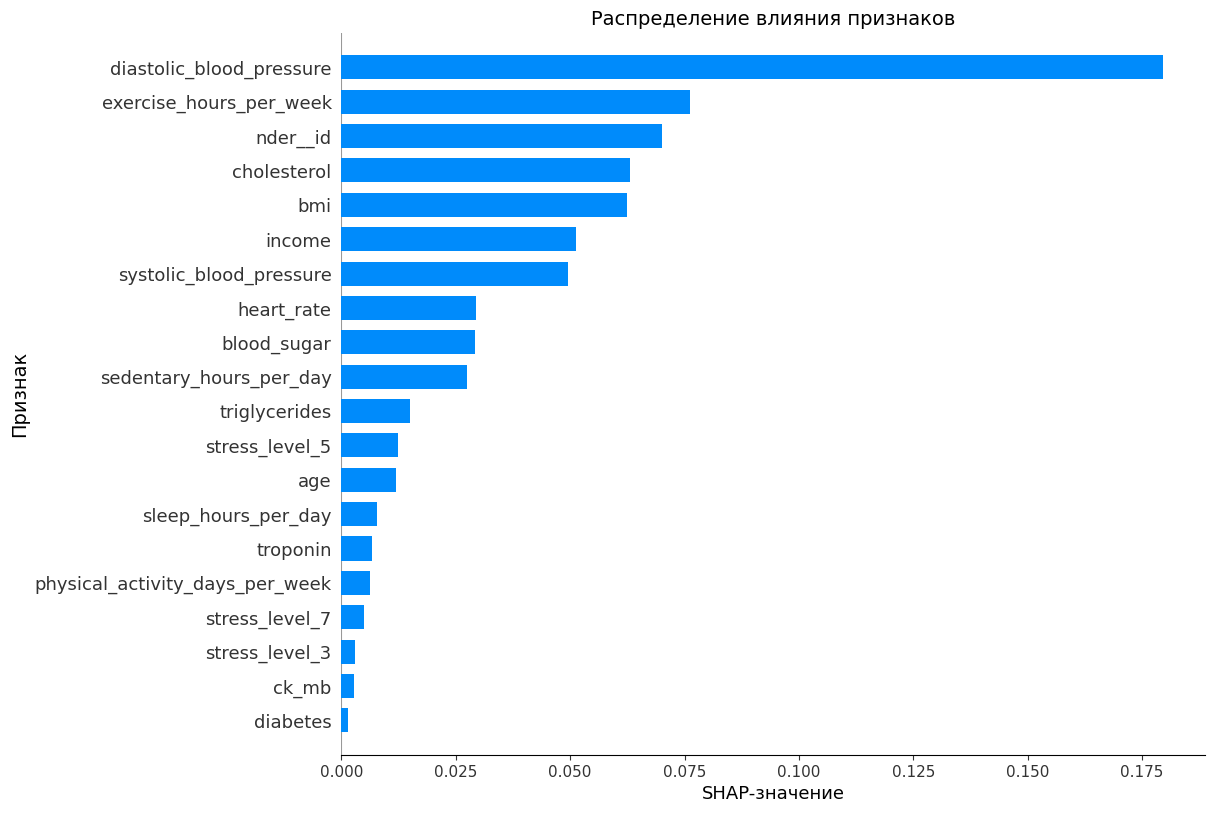

In [78]:
shap_summary_plot()

In [79]:
# Метод для расчета метрик и построения матрицы ошибок.
def calc_metric_reg(y_test, y_pred):

    # Расчитаем и выведем метрики.
    calc_metric(y_test, y_pred, y_pred, extend=False)

    # Построим матрицу ошибок методом from_estimator().
    sns.set_style('ticks')
    sns.heatmap(
        confusion_matrix(y_test, y_pred), 
        annot=True, 
        fmt='0', 
        cmap= 'coolwarm',
        linewidths=0.5,
        annot_kws={'size':str(12)},
        linecolor='black'
        )
    plt.title('Матрица ошибок', size=16)
    plt.ylabel('Истина')
    plt.xlabel('Прогноз')
    plt.show()

Метрика accuracy_score на тестовой выборке: 0.505
Метрика precision на тестовой выборке: 0.379
Метрика recall на тестовой выборке: 0.612


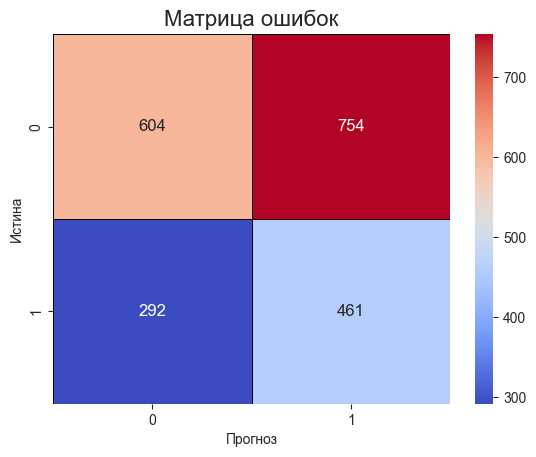

In [80]:
calc_metric_reg(y_test, y_test_pred)

Матрица ошибок позволяет различать четыре вида предсказаний модели: True Positive, True Negative, False Positive и False Negative. Прогнозы False Positive называют ошибками первого рода, а False Negative — ошибками второго рода.<br/>
Наша модель совершает ошибки FP чаще, чем FN, то есть эффективнее избегает ошибок второго типа.<br/>
Итого: модель 754 раза ошибочно предсказывает возникновение риска поражения сердца (ошибка 1-го рода) FP, и 292 раза — что вероятность возникновения отсутствует (ошибка 2-го рода) FN.<br/>
Исправить все ошибки сразу проблематично, во многих задачах бинарной классификации достаточно работать с ошибками одного типа. В нашем случае важно не ошибиться с предсказанием, что есть риск возникновения поражения сердца.<br/>
Лучше предупредить пациента о возникновении вероятности риска поражения сердца, чем ошибиться в обратном. С целью повышения фокуса на внимательное отношение пациента к своему здоровью.<br/>
По матрице ошибок можно определить, какая из метрик будет выше. Если ошибок FP больше, чем FN — то precision будет меньше, чем recall, и наоборот.<br/>
По метрике accuracy модель верно определяет класс heart_attack_risk_(binary) в ≈50.05% случаях, accuracy оценивает только то, сколько значений модель смогла правильно предсказать. Эта метрика не показывает, какой класс модель предсказывает лучше, а какой — хуже.
На данный момент модель ошибается в 49.95% случаев.<br/>
В процессе конфигурации пайплайна добились увеличения значения метрики recall, путем настройки гиперпараметоров модели RandomForestClassifier. Ключевую роль сыграл параметр class_weight.

In [81]:
# Сохранение лучшего пайплайна.
try:
    dump(randomized_search.best_estimator_, 'model/best_pipeline.joblib', compress=3)
except Exception as error:
    print(f'Ошибка при сохранении: {error}.')

print('Лучшие параметры:')
display(randomized_search.best_params_)

Лучшие параметры:


{'preprocessor__num': 'passthrough',
 'models__n_estimators': 100,
 'models__min_samples_split': 10,
 'models__min_samples_leaf': 1,
 'models__max_features': None,
 'models__max_depth': 15,
 'models__class_weight': {0: 1, 1: 2},
 'models__bootstrap': False,
 'models': RandomForestClassifier(random_state=42)}